# Sydney Air BnB Price Prediction EDA (Part 1)
## Institute of Data Capstone Project: Estimating Annual Earnings in Sydney's Housing Rental Market
### Wendy Maria D'Sa
##### NOTE: The below is just an overview. Please see Project documentation for detailed description and processes.

## What is the goal of the project?
* **Business Goal:** Assisting investment property owners estimate earnings either through short-term(180-days) or long-term rentals(> 180 days - effectively 6 months - 1 yr and above)
* **Data Goal:** Predicting AirBnB pricing for different types of properties across different geographical locations across Sydney. This pricing will help stakeholders estimate earning on short-term rentals.

## Data Acquisition
The dataset used for this project comes from Insideairbnb.com, an anti-Airbnb lobby group that scrapes Airbnb listings, reviews and calendar data for multiple cities around the world. The dataset was scraped on 7 December 2018 and contains information on all Sydney Airbnb listings that were live on the site on that date.

The data is rather messy, and has various limitations. The biggest challenge is that it only includes the advertised price called the 'sticker' price. The sticker price is the nightly price that is advertised to potential guests and can change dynamically, rather than the actual average amount actually paid per night by previous guests. The advertised prices can be set to any arbitrary amount, and hosts with less experience on Airbnb will often set these to very low or very high amounts.

Nevertheless, this dataset can be used as a base proof of concept. More accurate versions can be built using more precise data from sites like AirDNA, Transparent, etc. that sell higher quality Airbnb data.

* **Original Scraped Dataset link:** http://insideairbnb.com/get-the-data.html 
This datset has since been updated for 2021 and the 2018 dataset has been archived and is no longer available. For our predictions we would need to use pre-covid dataset as anything from January 2020 would not follow regular patterns and pricing in Sydney due to international and national border closure. 
* **Used dataset link:** https://www.kaggle.com/tylerx/sydney-airbnb-open-data
This dataset was extracted from the above inside airbnb link and posted on kaggle. The dataset is from listings in Dec 2018.

## Initial data pre-processing & cleaning in Excel
NLP will not be used in the creation of the initial model, since we are only interested in estimating earnings. Hence, the text columns were dropped, as were other columns not useful for predicting price (e.g. url, host name, and other features that are unrelated to the property).

* **Original dataset:** Contained 96 features and 36,662 observations. Some of the features were dropped in the excel file itself in order to import a more readable dataset. 
* **Features dropped in excel:** 
    * **scraped data info:** scrape_id
    * **listing information urls:** listing_url,  thumbnail_url, medium_url, picture_url, xl_picture_url
    * **listing string descriptions:** name, summary, space, description, neighborhood_overview, notes, transit, access, interaction, house_rules
    * **other listing information:** experiences_offered(blank), square_feet (over 90% blank)
    * **host information urls:** host_url, host_thumbnail_url, host_picture_url 
    * **host string descriptions:** host_name, host_about, host_verifications 
    * **other host information not relevant:** host_id, host_acceptance_rate (blank), host_neighbourhood (similar to host_location), host_listings_count (similar to host_total_listings_count), calculated_host_listings_count, host_has_profile_pic, host_identity_verified
    * **redundant geographical information:** street (string information - similar to neighbourhood/neighbourhood_cleansed/city), neighbourhood_cleansed (similar to neighbourhood/city), neighbourhood_group_cleansed (blank), city (similar to neighbourhood), state, market, smart_location (similar to neighbourhood), country_code, country, is_location_exact
    * **calendar information:** calendar_updated, calendar_last_scraped, has_availability 
    * **review information:** first_review, last_review, reviews_per_month (similar to number_of_reviews)
    * **business information:** requires_license, license, jurisdiction_names, is_business_travel_ready
* **Data added from outside:**
    * **Geographical information:** 
        * 'neighbourhood' feature was cleaned and backward geo-verified wrt to city, zipcode, latitude, and longitude.'neighbourhood' changed to 'suburb'
        * 'lga' feature was added to cluster the neighbourhood values according to respective lga to bring down the number of neighbourhoods
        * 'dist_to_cbd' was added as distance of suburb from cbd (townhall as centre) and further numerically encoded: <= 5km = 1, <= 10km = 2, <=15km = 3, <= 20km = 4, <= 25km = 5, and 25km+ = 6
        * 'cafe_density' was added from domain.com information (5 = best to 1 = worst)
        * 'transport_rating' was added from domain.com information (5 = best to 1 = worst)
        * 'beach_access' was added by geocoding centre of suburb to beach access (<= 2km = 5, <= 4km = 4, <=6km = 3, <= 8km = 2, 8km+ = 1)
        * 'cultural_access' was added by geocoding centre of suburb to tourist centres (museums, arts, galleries, shopping, theatres...etc) (<= 2km = 5, <= 4km = 4, <=6km = 3, <= 8km = 2, 8km+ = 1)
        * 'nat_park_access' was added by geocoding centre of suburb to large national parks and nature trails access (<= 2km = 5, <= 4km = 4, <=6km = 3, <= 8km = 2, 8km+ = 1)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy import stats
import statsmodels.graphics.gofplots as sm
import math
from datetime import datetime
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics

import xgboost as XGB
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor


plt.style.use('fivethirtyeight') #ggplot #fivethirtyeight #seaborn-dark

font = {'family' : 'Georgia',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

## Load datafile

In [2]:
bnb_csv = 'bnb_listings.csv'
bnb_data = pd.read_csv(bnb_csv, low_memory=False)

# To view all columns
# pd.set_option('display.max_columns', len(bnb_data.columns)) 
bnb_data.head()

,id,host_location,host_since,date_scraped,response_time,response_rate,superhost,host_listings,suburb,lga,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
0,12351.0,local,14/05/2009,07/12/2018,within a few hours,100%,0.0,2.0,Pyrmont,Sydney,...,10.0,9.0,10.0,10.0,10.0,10.0,0.0,3.0,1.0,1.0
1,14250.0,local,20/11/2009,07/12/2018,within a few hours,90%,0.0,2.0,Balgowlah,Northern Beaches,...,10.0,10.0,10.0,8.0,10.0,10.0,0.0,3.0,0.0,0.0
2,15253.0,local,03/12/2009,07/12/2018,within an hour,100%,0.0,2.0,Darlinghurst,Sydney,...,9.0,9.0,9.0,9.0,9.0,9.0,1.0,3.0,0.0,0.0
3,20865.0,local,19/12/2009,07/12/2018,within a day,100%,1.0,2.0,Balmain,Inner West,...,9.0,9.0,9.0,10.0,10.0,9.0,0.0,3.0,1.0,1.0
4,26174.0,local,19/04/2010,07/12/2018,NaN,NaN,0.0,1.0,Bellevue Hill,Woollahra,...,10.0,10.0,10.0,10.0,10.0,9.0,0.0,2.0,0.0,0.0


In [3]:
print(f"The dataset contains {bnb_data.shape[0]} rows and {bnb_data.shape[1]} columns")

The dataset contains 36667 rows and 52 columns


In [4]:
print(bnb_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36667 entries, 0 to 36666
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           36662 non-null  float64
 1   host_location                36662 non-null  object 
 2   host_since                   36656 non-null  object 
 3   date_scraped                 36662 non-null  object 
 4   response_time                18778 non-null  object 
 5   response_rate                18778 non-null  object 
 6   superhost                    36656 non-null  float64
 7   host_listings                36656 non-null  float64
 8   suburb                       36662 non-null  object 
 9   lga                          36662 non-null  object 
 10  zipcode                      36662 non-null  float64
 11  latitude                     36663 non-null  object 
 12  longitude                    36662 non-null  float64
 13  dist_to_cbd     

In [5]:
print(bnb_data.isnull().sum())

id                                 5
host_location                      5
host_since                        11
date_scraped                       5
response_time                  17889
response_rate                  17889
superhost                         11
host_listings                     11
suburb                             5
lga                                5
zipcode                            5
latitude                           4
longitude                          5
dist_to_cbd                        5
cafe_density                     280
transport_rating                 280
beach_access                     280
cultural_access                  280
nat_park_access                  280
property_type                      5
room_type                          5
accommodates                       5
bathrooms                         24
bedrooms                          14
beds                              44
bed_type                           5
amenities                          5
p

## Data Cleaning
### 1. Removing initial null values.
   * **Overall the data features are either objects or floats.**
   * **Many of the features have almost 1/3rd of values that are null values or empty.**
   * **We will start with cleaning out some of the null values.**

In [6]:
bnb_data[bnb_data.id.isnull()]

,id,host_location,host_since,date_scraped,response_time,response_rate,superhost,host_listings,suburb,lga,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
36662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# drop the above rows as it is not part of the original dataset
bnb_data = bnb_data[bnb_data.id.notna()]

In [8]:
print(bnb_data.shape)

(36662, 52)


### 2. Use id as the index
* **This could be useful in the future e.g. if a separate dataset containing reviews for each property is linked to this one.**

In [9]:
# convert id to interger 
bnb_data['id'] = bnb_data.id.astype('int32')

# convert id to index
bnb_data.set_index('id', inplace=True) 

In [10]:
bnb_data.head(3)

,host_location,host_since,date_scraped,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
12351,local,14/05/2009,07/12/2018,within a few hours,100%,0.0,2.0,Pyrmont,Sydney,2009.0,...,10.0,9.0,10.0,10.0,10.0,10.0,0.0,3.0,1.0,1.0
14250,local,20/11/2009,07/12/2018,within a few hours,90%,0.0,2.0,Balgowlah,Northern Beaches,2093.0,...,10.0,10.0,10.0,8.0,10.0,10.0,0.0,3.0,0.0,0.0
15253,local,03/12/2009,07/12/2018,within an hour,100%,0.0,2.0,Darlinghurst,Sydney,2010.0,...,9.0,9.0,9.0,9.0,9.0,9.0,1.0,3.0,0.0,0.0


### 3. Drop the rows where cafe_density has null values 
* **The suburbs that we will look at will be the suburbs listed on the domain.com data map and all other suburbs will be dropped.**
* **The null value suburbs in the cafe_density feature did not confirm to the suburbs in the domain.com dataset and are located at the fringes of Greater Sydney. These were dropped.**

In [11]:
bnb_data = bnb_data[bnb_data.cafe_density.notna()]

In [12]:
print(bnb_data.isnull().sum())

host_location                      0
host_since                         6
date_scraped                       0
response_time                  17837
response_rate                  17837
superhost                          6
host_listings                      6
suburb                             0
lga                                0
zipcode                            0
latitude                           0
longitude                          0
dist_to_cbd                        0
cafe_density                       0
transport_rating                   0
beach_access                       0
cultural_access                    0
nat_park_access                    0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         19
bedrooms                           9
beds                              39
bed_type                           0
amenities                          0
price                              0
w

In [13]:
print(bnb_data.shape)

(36387, 51)


### 4. Drop weekly_price and monthly_price 
* **These have over 90% null values.**

In [14]:
bnb_data.drop(['weekly_price', 'monthly_price'], axis=1, inplace=True)

In [15]:
print(f"The dataset contains {bnb_data.shape[0]} rows and {bnb_data.shape[1]} columns")

The dataset contains 36387 rows and 49 columns


### 5. Cleaning individual columns
* **Room_type: only keep observations of entire home/apt.**
    * The project goal is to estimate earnings for investment property owners who want to make a decision whether to go short-term or long-term due to the new NSW ruling on short-term rentals.
    * Only empty properties (investment properties and not owner occupied) have to confirm to the 180-day ruling.
    * Hence we remove all observations that are private rooms and shared rooms. Private rooms can be added as another layer on the application, but at this time is out of our scope of work. 

In [16]:
# get names of indexes for which column room_type has value shared room
index_names = bnb_data[bnb_data['room_type'] == 'Shared room'].index

# delete the row indexes from dataframe
bnb_data.drop(index_names, inplace=True)

print(bnb_data.shape)

(35758, 49)


In [17]:
# get names of indexes for which column room_type has value private room
index_names = bnb_data[bnb_data['room_type'] == 'Private room'].index

# delete the row indexes from dataframe
bnb_data.drop(index_names, inplace=True)

print(bnb_data.shape)

(22705, 49)


* **Property_type: Some cleaning of property types is required as there are a large number of categories with only a few listings.** 
    * The categories 'apartment' and 'house' will be used as most property owners will be interested in earnings on physical properties.
    * Any commercial property types such as hostels and hotels will also be removed as these are commercial ventures and do not have to confirm to the new laws

In [18]:
# get a list of all property_types
bnb_data.property_type.unique()

array(['House', 'Apartment', 'Guest suite', 'Loft', 'Guesthouse', 'Villa',
       'Townhouse', 'Bed and breakfast', 'Cabin', 'Condominium',
       'Bungalow', 'Cottage', 'Serviced apartment', 'Castle', 'Camper/RV',
       'Campsite', 'Other', 'Dome house', 'Tiny house', 'Treehouse',
       'Boat', 'Train', 'Island', 'Resort', 'Hotel', 'Chalet', 'Tent',
       'Yurt', 'Barn', 'Cave', 'Boutique hotel', 'Casa particular (Cuba)'],
      dtype=object)

In [19]:
bnb_data.property_type.value_counts()

Apartment                 14505
House                      5409
Townhouse                   771
Condominium                 479
Guest suite                 367
Guesthouse                  308
Loft                        212
Serviced apartment          160
Villa                       133
Bungalow                    101
Cottage                      85
Other                        45
Cabin                        44
Boat                         24
Tiny house                   16
Camper/RV                    10
Bed and breakfast             7
Chalet                        7
Tent                          5
Resort                        2
Island                        2
Treehouse                     2
Campsite                      2
Train                         1
Castle                        1
Hotel                         1
Dome house                    1
Yurt                          1
Barn                          1
Cave                          1
Boutique hotel                1
Casa par

In [20]:
# replacing categories that are types of houses or apartments
bnb_data.property_type.replace({'Townhouse': 'House', 'Condominium': 'Apartment', 'Guest suite': 'Apartment', 'Guesthouse': 'House', 'Villa': 'House', 'Loft': 'Apartment', 'Bungalow': 'House', 'Cottage': 'House', 'Tiny house': 'House', 'Earth house': 'House', 'Chalet': 'House', 'Castle': 'House', 'Dome house': 'House', 'Barn': 'House'}, inplace=True)

# replacing other categories with 'other'
bnb_data.loc[~bnb_data.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [21]:
# get names of indexes for which column property_type has value other
index_names = bnb_data[bnb_data['property_type'] == 'Other'].index

# delete the row indexes from dataframe
bnb_data.drop(index_names, inplace=True)

print(bnb_data.shape)

(22396, 49)


In [22]:
bnb_data.property_type.value_counts()

Apartment    15563
House         6833
Name: property_type, dtype: int64

* **Host_since: This is a datetime column, and will be converted into a measure of the number of years that a host has been on the platform.** 
    * Measured from the date that the data was scraped (7 December 2018).

In [23]:
# Converting to datetime
bnb_data.host_since = pd.to_datetime(bnb_data.host_since, dayfirst=True) 
bnb_data.date_scraped = pd.to_datetime(bnb_data.date_scraped, dayfirst=True)

# Calculating the number of days
days = (bnb_data.date_scraped - bnb_data.host_since).astype('timedelta64[D]')

# insert calculated value after date_scraped
bnb_data.insert(loc=3, column='host_experience', value=days)

bnb_data.head(3)

,host_location,host_since,date_scraped,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
14250,local,2009-11-20,2018-12-07,3304.0,within a few hours,90%,0.0,2.0,Balgowlah,Northern Beaches,...,10.0,10.0,10.0,8.0,10.0,10.0,0.0,3.0,0.0,0.0
20865,local,2009-12-19,2018-12-07,3275.0,within a day,100%,1.0,2.0,Balmain,Inner West,...,9.0,9.0,9.0,10.0,10.0,9.0,0.0,3.0,1.0,1.0
38073,local,2010-04-04,2018-12-07,3169.0,NaN,NaN,0.0,1.0,North Sydney,North Sydney,...,10.0,10.0,10.0,10.0,9.0,9.0,0.0,3.0,1.0,1.0


In [24]:
print(f'Number of null observations: {bnb_data.host_experience.isnull().sum()}')
print(f'Min days as host: {bnb_data.host_experience.min()}')
print(f'Max days as host: {bnb_data.host_experience.max()}')
print(f'Mean days as host: {round(bnb_data.host_experience.mean())}')
print(f'Median days as host: {bnb_data.host_experience.median()}')

Number of null observations: 4
Min days as host: 1.0
Max days as host: 3575.0
Mean days as host: 1293
Median days as host: 1273.0


In [25]:
# replacing null values with the median
bnb_data.host_experience.fillna(bnb_data.host_experience.median(), inplace=True)

In [26]:
# converting host_experience to years
years = bnb_data.host_experience/365
bnb_data['host_experience'] = years
bnb_data['host_experience'] = bnb_data['host_experience'].apply(np.ceil) 

In [27]:
bnb_data.host_experience.value_counts()

4.0     4638
5.0     4267
3.0     3751
6.0     2661
2.0     2514
1.0     2318
7.0     1516
8.0      503
9.0      202
10.0      26
Name: host_experience, dtype: int64

In [28]:
bnb_data.drop(['host_since', 'date_scraped'], axis=1, inplace=True)

* **Host_response_time: Almost 45% have null values**
    * these may consist of properties properties which have not yet had a booking or properties where a booking is in progress. 
    * these listings may also contain a large number of properties which have been speculatively listed on Airbnb but either have their calendars closed or have prices which are notably higher than other properties in the area. The latter occurs when people who live on a property put their property on Airbnb at a high price just to see if anyone is willing to book at that price. If property is booked, they decamp to another property or to a cheaper hotel for those dates, and pocket the difference in price.
    * because value is unknown for so many listings, we will assign "a few days or more" assuming that a host will respond eventually
    * we will then encode the values into binary form: within a day: t = 1 and not within a day: f = 0

In [29]:
print(f'Null values: {bnb_data.response_time.isnull().sum()}')
print(f'Percentage of Null values: {bnb_data.response_time.isnull().sum()/len(bnb_data)*100:.2f}')

Null values: 10279
Percentage of Null values: 45.90


In [30]:
# replace all null values to 'a few days or more'
bnb_data.response_time.fillna('a few days or more', inplace=True)

In [31]:
bnb_data.response_time.value_counts()

a few days or more    10614
within an hour         7661
within a few hours     2188
within a day           1933
Name: response_time, dtype: int64

In [32]:
# replacing categories that are within the day as 1 and more than a day (not within a day) as 0
bnb_data.response_time.replace({'a few days or more': 0, 'within an hour': 1, 'within a few hours': 1, 'within a day': 1}, inplace=True)
bnb_data.response_time.value_counts(normalize=True)

1    0.526076
0    0.473924
Name: response_time, dtype: float64

In [33]:
bnb_data.isnull().sum()

host_location                      0
host_experience                    0
response_time                      0
response_rate                  10279
superhost                          4
host_listings                      4
suburb                             0
lga                                0
zipcode                            0
latitude                           0
longitude                          0
dist_to_cbd                        0
cafe_density                       0
transport_rating                   0
beach_access                       0
cultural_access                    0
nat_park_access                    0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                          6
bedrooms                           5
beds                               9
bed_type                           0
amenities                          0
price                              0
security_deposit                6033
c

* **Host_response_rate: Almost 45% have null values**
    * most hosts have a good response rate
    * replace response rate with mean value

In [34]:
print(f'Null values: {bnb_data.response_rate.isnull().sum()}')
print(f'Percentage of Null values: {bnb_data.response_rate.isnull().sum()/len(bnb_data)*100:.2f}')

Null values: 10279
Percentage of Null values: 45.90


In [35]:
# Removing the % sign from the response_rate string and converting to an integer
bnb_data.response_rate = bnb_data.response_rate.str[:-1].astype('float64')

In [36]:
print(f'Mean response rate: {(bnb_data.response_rate.mean())}')
print(f'Median response rate: {(bnb_data.response_rate.median())}')
print(f'Proportion of 100% host response rates: {round(((bnb_data.response_rate == 100.0).sum()/bnb_data.response_rate.count())*100)}%')

Mean response rate: 94.42494016670793
Median response rate: 100.0
Proportion of 100% host response rates: 75%


In [37]:
# Replacing null values with the mean
bnb_data.response_rate.fillna(round(bnb_data.response_rate.mean()), inplace=True)

In [38]:
bnb_data.isnull().sum()

host_location                     0
host_experience                   0
response_time                     0
response_rate                     0
superhost                         4
host_listings                     4
suburb                            0
lga                               0
zipcode                           0
latitude                          0
longitude                         0
dist_to_cbd                       0
cafe_density                      0
transport_rating                  0
beach_access                      0
cultural_access                   0
nat_park_access                   0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         6
bedrooms                          5
beds                              9
bed_type                          0
amenities                         0
price                             0
security_deposit               6033
cleaning_fee                

In [39]:
bnb_data.response_rate.unique()

array([ 90., 100.,  94.,  97.,  80.,  71.,  67.,  86.,   0.,  33.,  56.,
        70.,  50.,  43.,  88.,  89.,  75.,  17.,  74.,  98.,  83.,  78.,
        29.,  92.,  87.,  95.,  91.,  60.,  40.,  84.,  96.,  68.,  76.,
        20.,  30.,  13.,  99.,  82.,  85.,  25.,  63.,  69.,  93.,  57.,
        38.,  73.,  53.,   8.,  11.,  65.,  14.,  77.,  44.,  79.,  22.,
        62.,  81.])

In [40]:
bnb_data.head()

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
14250,local,10.0,1,90.0,0.0,2.0,Balgowlah,Northern Beaches,2093.0,-33.80092903,...,10.0,10.0,10.0,8.0,10.0,10.0,0.0,3.0,0.0,0.0
20865,local,9.0,1,100.0,1.0,2.0,Balmain,Inner West,2041.0,-33.85907161,...,9.0,9.0,9.0,10.0,10.0,9.0,0.0,3.0,1.0,1.0
38073,local,9.0,0,94.0,0.0,1.0,North Sydney,North Sydney,2060.0,-33.83442928,...,10.0,10.0,10.0,10.0,9.0,9.0,0.0,3.0,1.0,1.0
39348,local,9.0,0,94.0,0.0,2.0,North Bondi,Waverley,2026.0,-33.88482062,...,8.0,8.0,9.0,10.0,8.0,8.0,1.0,3.0,0.0,0.0
44545,local,9.0,0,94.0,0.0,1.0,Darlinghurst,Sydney,2010.0,-33.87995629,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,3.0,0.0,1.0


In [41]:
bnb_data.response_rate.value_counts()

94.0     10315
100.0     9032
99.0       525
90.0       292
98.0       245
80.0       241
0.0        223
50.0       173
97.0       154
67.0       126
96.0       121
89.0        92
83.0        77
85.0        67
75.0        66
86.0        63
91.0        62
95.0        60
60.0        50
92.0        50
88.0        47
70.0        42
33.0        33
93.0        23
40.0        21
68.0        19
25.0        19
82.0        18
65.0        15
78.0        14
71.0        12
43.0        11
84.0         9
20.0         8
73.0         8
77.0         7
57.0         7
76.0         6
81.0         5
38.0         4
69.0         4
56.0         4
17.0         4
29.0         3
63.0         3
87.0         3
13.0         2
30.0         2
53.0         1
8.0          1
11.0         1
14.0         1
74.0         1
44.0         1
79.0         1
22.0         1
62.0         1
Name: response_rate, dtype: int64

* **Host_location: was changed during initial pre-processing in excel into 3 categories - local, other state, international - based on host_location and host_suburb features.**
    * only about 4% of hosts are international
    * further reduce the 3 categories to binary form: local & other state = 1, international(not local) = 0 

In [42]:
bnb_data.host_location.value_counts(normalize=True)

local            0.937132
international    0.039561
other state      0.023308
Name: host_location, dtype: float64

In [43]:
# replacing categories that are local and other state as 1 and international as 0
bnb_data.host_location.replace({'local': 1, 'international': 0, 'other state': 1}, inplace=True)
bnb_data.host_location.value_counts(normalize=True)

1    0.960439
0    0.039561
Name: host_location, dtype: float64

* **Superhost: was changed to binary form in excel with t=1 and f=0.**
    * most of the null values observations have no reviews
    * the superhost designation on Airbnb is a sign that an Airbnb host has gotten consistently good reviews over at least a year of hosting. Since, most of the null observations have 0-2 reviews it is safe to say that they are not superhosts
    * assign value 0 to the null values

In [44]:
bnb_data[bnb_data.superhost.isnull()]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
7903943,1,4.0,0,94.0,NaN,NaN,Camperdown,Sydney,2050.0,-33.8932414,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
9374735,1,4.0,0,94.0,NaN,NaN,Bronte,Waverley,2024.0,-33.9056198,...,8.0,10.0,10.0,10.0,8.0,7.0,0.0,3.0,0.0,0.0
10144746,1,4.0,0,94.0,NaN,NaN,Rose Bay,Woollahra,2029.0,-33.87086121,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
15694161,1,4.0,0,94.0,NaN,NaN,North Bondi,Waverley,2026.0,-33.88029767,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0


In [45]:
# replace null values with 0
bnb_data.superhost.replace(np.nan, 0, inplace=True)

* **Host_listings: same observations as the superhosts with null values.**
    * replace null values and 0 values with 1 as they have atleast 1 listing

In [46]:
# replace null values and 0 values with 1
bnb_data.host_listings.replace(np.nan, 1, inplace=True)
bnb_data.host_listings.replace(0, 1, inplace=True)

In [47]:
bnb_data.host_listings.unique()

array([  2.,   1.,  10.,  54.,   3.,   4.,   5.,  19.,   8.,  48.,   7.,
        38.,   9.,  15.,  31.,  11.,  51., 203.,   6.,  20.,  16.,  60.,
        12.,  24., 125.,  86.,  55., 104.,  28.,  14., 124.,  21.,  30.,
        26.,  17.,  13.,  33.,  95.,  39.,  57.,  34.,  87., 276.,  29.,
        18.,  35.,  22., 182., 166.,  40.,  71.,  23.,  61.,  78.,  49.,
        36., 135.,  32.,  58.,  44.,  72.,  52.])

In [48]:
bnb_data.head(3)

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
14250,1,10.0,1,90.0,0.0,2.0,Balgowlah,Northern Beaches,2093.0,-33.80092903,...,10.0,10.0,10.0,8.0,10.0,10.0,0.0,3.0,0.0,0.0
20865,1,9.0,1,100.0,1.0,2.0,Balmain,Inner West,2041.0,-33.85907161,...,9.0,9.0,9.0,10.0,10.0,9.0,0.0,3.0,1.0,1.0
38073,1,9.0,0,94.0,0.0,1.0,North Sydney,North Sydney,2060.0,-33.83442928,...,10.0,10.0,10.0,10.0,9.0,9.0,0.0,3.0,1.0,1.0


* **Price: is currently a string since it has $ sign.**
    * remove dollar sign
    * convert to an integer

In [49]:
# remove dollar sign
bnb_data['price'] = bnb_data.price.replace({r'\$':''}, regex=True)
bnb_data['price'] = bnb_data.price.replace({r'\,':''}, regex=True)

In [50]:
# convert to number type
bnb_data['price'] = bnb_data.price.astype('float64')

In [51]:
bnb_data.price.isnull().sum()

0

* **Security_deposit: is currently a string since it has $ sign.**
    * remove dollar sign
    * convert to an integer
    * missing value for security deposit is functionally the same as no security deposit, so missing values will be replaced with 0

In [52]:
# remove $ sign
bnb_data['security_deposit'] = bnb_data.security_deposit.replace({r'\$':''}, regex=True)
bnb_data['security_deposit'] = bnb_data.security_deposit.replace({r'\,':''}, regex=True)

In [53]:
# fill null values with 0
bnb_data.security_deposit.fillna(0, inplace=True)

In [54]:
# convert to number type
bnb_data['security_deposit'] = bnb_data.security_deposit.astype('float64')

* **Cleaning_fee: is currently a string since it has $ sign.**
    * remove dollar sign
    * convert to an integer
    * missing value for cleaning fee is functionally the same as no cleaning fee, so missing values will be replaced with 0

In [55]:
# remove $ sign
bnb_data['cleaning_fee'] = bnb_data.cleaning_fee.replace({r'\$':''}, regex=True)
bnb_data['cleaning_fee'] = bnb_data.cleaning_fee.replace({r'\,':''}, regex=True)

In [56]:
# fill null values with 0
bnb_data.cleaning_fee.fillna(0, inplace=True)

In [57]:
# convert to number type
bnb_data['cleaning_fee'] = bnb_data.cleaning_fee.astype('float64')

* **Extra_people: is currently a string since it has $ sign.**
    * remove dollar sign
    * convert to an integer
    * missing value for extra people is functionally the same as no extra people fee, so missing values will be replaced with 0

In [58]:
# remove $ sign
bnb_data['extra_people'] = bnb_data.extra_people.replace({r'\$':''}, regex=True)
bnb_data['extra_people'] = bnb_data.extra_people.replace({r'\,':''}, regex=True)

In [59]:
# fill null values with 0
bnb_data.extra_people.fillna(0, inplace=True)

In [60]:
# convert to number type
bnb_data['extra_people'] = bnb_data.extra_people.astype('float64')

In [61]:
bnb_data.isnull().sum()

host_location                     0
host_experience                   0
response_time                     0
response_rate                     0
superhost                         0
host_listings                     0
suburb                            0
lga                               0
zipcode                           0
latitude                          0
longitude                         0
dist_to_cbd                       0
cafe_density                      0
transport_rating                  0
beach_access                      0
cultural_access                   0
nat_park_access                   0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         6
bedrooms                          5
beds                              9
bed_type                          0
amenities                         0
price                             0
security_deposit                  0
cleaning_fee                

In [62]:
bnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_location                22396 non-null  int64  
 1   host_experience              22396 non-null  float64
 2   response_time                22396 non-null  int64  
 3   response_rate                22396 non-null  float64
 4   superhost                    22396 non-null  float64
 5   host_listings                22396 non-null  float64
 6   suburb                       22396 non-null  object 
 7   lga                          22396 non-null  object 
 8   zipcode                      22396 non-null  float64
 9   latitude                     22396 non-null  object 
 10  longitude                    22396 non-null  float64
 11  dist_to_cbd                  22396 non-null  float64
 12  cafe_density                 22396 non-null  float64
 13  transport

* **Review_scores_rating | review_scores_accuracy | review_scores_cleanliness | review_scores_checkin | review_scores_communication | review_scores_location | review_scores_value: more than 1/3rd of the observations in these features have null values.This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and therefore price.**
    * these are also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. 
    * the missing values here are NaNs which tells us that these are either new or previously unbooked listings that have not yet had reviews. 
    * it is actually useful to keep them in so that the resulting model may be able to predict prices for any listing, including new listings or listings with 0 reviews.
    * groupby number_of_reviews = 0 and assign these observations as 0. 
    * for remaining impute with groupby number of reviews and median

In [63]:
bnb_data.number_of_reviews.value_counts()

0.0      6762
1.0      3110
2.0      1831
3.0      1237
4.0       913
         ... 
396.0       1
214.0       1
324.0       1
215.0       1
211.0       1
Name: number_of_reviews, Length: 259, dtype: int64

In [64]:
print(f'''
review_scores_rating: {bnb_data.review_scores_rating.isnull().sum()}
review_scores_accuracy: {bnb_data.review_scores_accuracy.isnull().sum()}
review_scores_cleanliness: {bnb_data.review_scores_cleanliness.isnull().sum()}
review_scores_checkin: {bnb_data.review_scores_checkin.isnull().sum()}
review_scores_communication: {bnb_data.review_scores_communication.isnull().sum()}
review_scores_location: {bnb_data.review_scores_location.isnull().sum()}
review_scores_value: {bnb_data.review_scores_value.isnull().sum()}''')


review_scores_rating: 7415
review_scores_accuracy: 7442
review_scores_cleanliness: 7427
review_scores_checkin: 7456
review_scores_communication: 7433
review_scores_location: 7455
review_scores_value: 7457


In [65]:
bnb_data.loc[(bnb_data.number_of_reviews == 0.0) & (bnb_data.review_scores_rating.isnull())]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
58954,1,9.0,0,94.0,0.0,1.0,Bondi Junction,Waverley,2022.0,-33.8917631,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0
69121,1,8.0,1,100.0,0.0,1.0,Narrabeen,Northern Beaches,2101.0,-33.71249286,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0
249847,1,8.0,0,94.0,0.0,1.0,Manly,Northern Beaches,2095.0,-33.79962594,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0
279082,1,8.0,0,94.0,0.0,1.0,Newport,Northern Beaches,2106.0,-33.65760918,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0
440213,1,7.0,0,94.0,0.0,1.0,Darling Point,Woollahra,2027.0,-33.87354926,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30591608,1,6.0,1,98.0,0.0,203.0,Bondi Beach,Waverley,2026.0,-33.88842485,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.0,0.0
30591716,1,5.0,0,94.0,0.0,1.0,Manly,Northern Beaches,2095.0,-33.7974274,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0
30591867,1,1.0,0,94.0,0.0,1.0,Vaucluse,Woollahra,2030.0,-33.86391139,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0


In [66]:
bnb_data.loc[(bnb_data.number_of_reviews == 0.0) & (bnb_data.review_scores_rating.isnull()), 'review_scores_rating'] = 0.0
bnb_data.loc[(bnb_data.number_of_reviews == 0.0) & (bnb_data.review_scores_accuracy.isnull()), 'review_scores_accuracy'] = 0.0
bnb_data.loc[(bnb_data.number_of_reviews == 0.0) & (bnb_data.review_scores_cleanliness.isnull()), 'review_scores_cleanliness'] = 0.0
bnb_data.loc[(bnb_data.number_of_reviews == 0.0) & (bnb_data.review_scores_checkin.isnull()), 'review_scores_checkin'] = 0.0
bnb_data.loc[(bnb_data.number_of_reviews == 0.0) & (bnb_data.review_scores_communication.isnull()), 'review_scores_communication'] = 0.0
bnb_data.loc[(bnb_data.number_of_reviews == 0.0) & (bnb_data.review_scores_location.isnull()), 'review_scores_location'] = 0.0
bnb_data.loc[(bnb_data.number_of_reviews == 0.0) & (bnb_data.review_scores_value.isnull()), 'review_scores_value'] = 0.0

In [67]:
print(f'''
review_scores_rating: {bnb_data.review_scores_rating.isnull().sum()}
review_scores_accuracy: {bnb_data.review_scores_accuracy.isnull().sum()}
review_scores_cleanliness: {bnb_data.review_scores_cleanliness.isnull().sum()}
review_scores_checkin: {bnb_data.review_scores_checkin.isnull().sum()}
review_scores_communication: {bnb_data.review_scores_communication.isnull().sum()}
review_scores_location: {bnb_data.review_scores_location.isnull().sum()}
review_scores_value: {bnb_data.review_scores_value.isnull().sum()}''')


review_scores_rating: 653
review_scores_accuracy: 680
review_scores_cleanliness: 665
review_scores_checkin: 694
review_scores_communication: 671
review_scores_location: 693
review_scores_value: 695


In [68]:
bnb_data.review_scores_rating.median()

92.0

In [69]:
bnb_data.groupby(['number_of_reviews'])['review_scores_rating'].median()

number_of_reviews
0.0        0.0
1.0      100.0
2.0      100.0
3.0       93.0
4.0       95.0
         ...  
385.0     88.0
391.0     98.0
392.0     94.0
396.0     97.0
443.0     98.0
Name: review_scores_rating, Length: 259, dtype: float64

In [70]:
# fill null values with groupby median
bnb_data.review_scores_rating.fillna(bnb_data.groupby(['number_of_reviews'])['review_scores_rating'].transform('median'), inplace=True)

In [71]:
bnb_data.review_scores_rating.isnull().sum()

0

In [72]:
bnb_data.review_scores_accuracy.median()

9.0

In [73]:
bnb_data.groupby(['number_of_reviews'])['review_scores_accuracy'].median()

number_of_reviews
0.0       0.0
1.0      10.0
2.0      10.0
3.0      10.0
4.0      10.0
         ... 
385.0     9.0
391.0    10.0
392.0    10.0
396.0    10.0
443.0    10.0
Name: review_scores_accuracy, Length: 259, dtype: float64

In [74]:
# fill null values with groupby median
bnb_data.review_scores_accuracy.fillna(bnb_data.groupby(['number_of_reviews'])['review_scores_accuracy'].transform('median'), inplace=True)

In [75]:
bnb_data.review_scores_cleanliness.median()

9.0

In [76]:
bnb_data.groupby(['number_of_reviews'])['review_scores_cleanliness'].median()

number_of_reviews
0.0       0.0
1.0      10.0
2.0      10.0
3.0       9.0
4.0      10.0
         ... 
385.0     9.0
391.0    10.0
392.0     9.0
396.0    10.0
443.0    10.0
Name: review_scores_cleanliness, Length: 259, dtype: float64

In [77]:
# fill null values with groupby median
bnb_data.review_scores_cleanliness.fillna(bnb_data.groupby(['number_of_reviews'])['review_scores_cleanliness'].transform('median'), inplace=True)

In [78]:
bnb_data.review_scores_checkin.median()

10.0

In [79]:
bnb_data.groupby(['number_of_reviews'])['review_scores_checkin'].median()

number_of_reviews
0.0       0.0
1.0      10.0
2.0      10.0
3.0      10.0
4.0      10.0
         ... 
385.0    10.0
391.0    10.0
392.0    10.0
396.0    10.0
443.0    10.0
Name: review_scores_checkin, Length: 259, dtype: float64

In [80]:
# fill null values with groupby median
bnb_data.review_scores_checkin.fillna(bnb_data.groupby(['number_of_reviews'])['review_scores_checkin'].transform('median'), inplace=True)

In [81]:
bnb_data.review_scores_communication.median()

10.0

In [82]:
bnb_data.groupby(['number_of_reviews'])['review_scores_communication'].median()

number_of_reviews
0.0       0.0
1.0      10.0
2.0      10.0
3.0      10.0
4.0      10.0
         ... 
385.0    10.0
391.0    10.0
392.0    10.0
396.0    10.0
443.0    10.0
Name: review_scores_communication, Length: 259, dtype: float64

In [83]:
# fill null values with groupby median
bnb_data.review_scores_communication.fillna(bnb_data.groupby(['number_of_reviews'])['review_scores_communication'].transform('median'), inplace=True)

In [84]:
bnb_data.review_scores_location.median()

10.0

In [85]:
bnb_data.groupby(['number_of_reviews'])['review_scores_location'].median()

number_of_reviews
0.0       0.0
1.0      10.0
2.0      10.0
3.0      10.0
4.0      10.0
         ... 
385.0     9.0
391.0    10.0
392.0    10.0
396.0    10.0
443.0    10.0
Name: review_scores_location, Length: 259, dtype: float64

In [86]:
# fill null values with groupby median
bnb_data.review_scores_location.fillna(bnb_data.groupby(['number_of_reviews'])['review_scores_location'].transform('median'), inplace=True)

In [87]:
bnb_data.review_scores_value.median()

9.0

In [88]:
bnb_data.groupby(['number_of_reviews'])['review_scores_value'].median()

number_of_reviews
0.0       0.0
1.0      10.0
2.0      10.0
3.0       9.0
4.0      10.0
         ... 
385.0     9.0
391.0    10.0
392.0     9.0
396.0    10.0
443.0    10.0
Name: review_scores_value, Length: 259, dtype: float64

In [89]:
# fill null values with groupby median
bnb_data.review_scores_value.fillna(bnb_data.groupby(['number_of_reviews'])['review_scores_value'].transform('median'), inplace=True)

In [90]:
bnb_data.isnull().sum()

host_location                  0
host_experience                0
response_time                  0
response_rate                  0
superhost                      0
host_listings                  0
suburb                         0
lga                            0
zipcode                        0
latitude                       0
longitude                      0
dist_to_cbd                    0
cafe_density                   0
transport_rating               0
beach_access                   0
cultural_access                0
nat_park_access                0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      6
bedrooms                       5
beds                           9
bed_type                       0
amenities                      0
price                          0
security_deposit               0
cleaning_fee                   0
guests_included                0
extra_people                   0
min_nights

* **Bedrooms: there are many observations with 0 bedrooms which would need to be rectified as they do list as entire house/apt, while there are 5 null value observations.**
    * convert bedrooms to integer as this cannot have fractions
    * replace 0 with null values
    * use groupby of property type, room type, suburb, accomodates to impute bedrooms

In [91]:
bnb_data[bnb_data.bedrooms.isnull()]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
1375398,1,6.0,1,100.0,0.0,1.0,Neutral Bay,North Sydney,2089.0,-33.83854905,...,9.0,8.0,10.0,10.0,9.0,9.0,0.0,2.0,0.0,0.0
3900144,1,7.0,1,100.0,1.0,1.0,Potts Point,Sydney,2011.0,-33.86790852,...,10.0,9.0,10.0,10.0,10.0,9.0,1.0,3.0,0.0,0.0
4015571,1,6.0,0,94.0,0.0,1.0,Elizabeth Bay,Sydney,2011.0,-33.87172286,...,10.0,8.0,10.0,10.0,10.0,9.0,0.0,3.0,0.0,0.0
8524383,1,4.0,1,100.0,0.0,3.0,Randwick,Randwick,2031.0,-33.90796652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
10688721,1,3.0,1,100.0,1.0,1.0,Zetland,Sydney,2017.0,-33.90964075,...,10.0,10.0,10.0,10.0,10.0,9.0,0.0,2.0,0.0,0.0


In [92]:
bnb_data.bedrooms.value_counts()

2.0     7696
1.0     7458
3.0     3132
4.0     1853
0.0     1563
5.0      576
6.0       95
7.0       15
9.0        2
10.0       1
Name: bedrooms, dtype: int64

In [93]:
# replace 0.0 values with NaN
bnb_data.bedrooms.replace(0.0, np.nan, inplace=True)

In [94]:
bnb_data.bedrooms.value_counts()

2.0     7696
1.0     7458
3.0     3132
4.0     1853
5.0      576
6.0       95
7.0       15
9.0        2
10.0       1
Name: bedrooms, dtype: int64

In [95]:
bnb_data.bedrooms.isnull().sum()

1568

In [96]:
# check extream values before imputing median
bnb_data.loc[bnb_data.bedrooms >= 7.0]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
7058170,1,4.0,0,94.0,0.0,1.0,Warriewood,Northern Beaches,2102.0,-33.69084265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
9155251,1,5.0,1,80.0,0.0,104.0,Palm Beach,Northern Beaches,2108.0,-33.59623073,...,10.0,10.0,10.0,10.0,10.0,8.0,0.0,5.0,0.0,0.0
9323120,1,5.0,1,90.0,0.0,2.0,Warriewood,Northern Beaches,2102.0,-33.70153188,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,3.0,0.0,0.0
14154801,1,4.0,1,70.0,0.0,1.0,Kensington,Randwick,2033.0,-33.90643182,...,9.0,9.0,10.0,10.0,10.0,10.0,0.0,3.0,0.0,0.0
14921505,1,6.0,1,93.0,1.0,4.0,Avalon Beach,Northern Beaches,2107.0,-33.6256373,...,10.0,9.0,10.0,10.0,10.0,9.0,0.0,3.0,0.0,0.0
15605281,1,5.0,1,91.0,1.0,124.0,Newport,Northern Beaches,2106.0,-33.66326921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
16634327,1,2.0,0,40.0,0.0,1.0,Mosman,Mosman,2088.0,-33.82945787,...,8.0,8.0,10.0,9.0,10.0,8.0,1.0,3.0,0.0,0.0
19422203,1,4.0,1,100.0,0.0,28.0,Seaforth,Northern Beaches,2092.0,-33.80311181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
21318734,1,3.0,1,100.0,0.0,6.0,Bankstown,Canterbury-Bankstown,2200.0,-33.91745722,...,9.0,9.0,10.0,9.0,9.0,9.0,1.0,3.0,0.0,0.0


In [97]:
bnb_data.bedrooms.median()

2.0

In [98]:
bnb_data.groupby(['property_type'])['bedrooms'].median()

property_type
Apartment    2.0
House        3.0
Name: bedrooms, dtype: float64

In [99]:
bnb_data.groupby(['property_type', 'accommodates'])['bedrooms'].median()

property_type  accommodates
Apartment      1.0             1.0
               2.0             1.0
               3.0             1.0
               4.0             2.0
               5.0             2.0
               6.0             2.0
               7.0             3.0
               8.0             3.0
               9.0             3.0
               10.0            3.0
               11.0            4.0
               12.0            4.5
               13.0            4.0
               14.0            3.0
               15.0            3.5
               16.0            1.0
House          1.0             1.0
               2.0             1.0
               3.0             2.0
               4.0             2.0
               5.0             3.0
               6.0             3.0
               7.0             4.0
               8.0             4.0
               9.0             4.0
               10.0            5.0
               11.0            5.0
               12.0        

In [100]:
bnb_data.groupby(['property_type', 'lga'])['bedrooms'].median()

property_type  lga             
Apartment      Bayside             2.0
               Blacktown           1.0
               Burwood             2.0
               Camden              2.0
               Campbelltown        1.0
                                  ... 
House          Sutherland Shire    3.0
               Sydney              2.0
               Waverley            3.0
               Willoughby          4.0
               Woollahra           3.0
Name: bedrooms, Length: 61, dtype: float64

   * **there are some extreme values to accommodates that do not realistically match the number of average bedrooms especially in apartments. While grouping by room and property type do seem more realistic, property sizes usually vary by suburb/lga. It would thus make more sense to impute using property type, room type, and lga**

In [101]:
# fill null values with groupby median
bnb_data.bedrooms.fillna(bnb_data.groupby(['property_type', 'lga'])['bedrooms'].transform('median'), inplace=True)

In [102]:
bnb_data.bedrooms.value_counts()

1.0     8422
2.0     8171
3.0     3209
4.0     1902
5.0      576
6.0       95
7.0       15
1.5        3
9.0        2
10.0       1
Name: bedrooms, dtype: int64

In [103]:
bnb_data.bedrooms.isnull().sum()

0

In [104]:
# convert bedrooms to interger 
bnb_data['bedrooms'] = bnb_data.bedrooms.astype('int64')

* **Beds: there are 89 beds that have 0 value and 9 null values.**
    * convert beds to integer as these cannot be fractions
    * convert 0 to null values
    * groupby bedrooms, property type, room type, and accomodates to impute for null values

In [105]:
bnb_data.beds.isnull().sum()

9

In [106]:
bnb_data.beds.value_counts()

1.0     7099
2.0     6682
3.0     3655
4.0     2384
5.0     1249
6.0      657
7.0      255
8.0      189
0.0       89
10.0      52
9.0       44
11.0      15
12.0       7
13.0       4
16.0       3
14.0       2
18.0       1
Name: beds, dtype: int64

In [107]:
# replace 0.0 values with NaN
bnb_data.beds.replace(0.0, np.nan, inplace=True)

In [108]:
bnb_data.beds.isnull().sum()

98

In [109]:
bnb_data.beds.value_counts()

1.0     7099
2.0     6682
3.0     3655
4.0     2384
5.0     1249
6.0      657
7.0      255
8.0      189
10.0      52
9.0       44
11.0      15
12.0       7
13.0       4
16.0       3
14.0       2
18.0       1
Name: beds, dtype: int64

In [110]:
# check extreme values of beds before imputing median. Check 18 beds
bnb_data.loc[bnb_data.beds >= 12.0]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
5685025,1,5.0,1,100.0,1.0,7.0,Bilgola Plateau,Northern Beaches,2107.0,-33.6419962,...,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,0.0,0.0
10536125,1,5.0,1,100.0,1.0,1.0,Arncliffe,Bayside,2205.0,-33.939411,...,10.0,10.0,10.0,10.0,9.0,10.0,1.0,3.0,0.0,0.0
14906472,1,3.0,1,100.0,1.0,1.0,Marrickville,Inner West,2204.0,-33.90670949,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,2.0,0.0,0.0
16421277,1,4.0,1,80.0,0.0,1.0,Northmead,Parramatta,2152.0,-33.79042675,...,8.0,8.0,9.0,9.0,9.0,8.0,0.0,3.0,0.0,0.0
17387039,1,5.0,1,100.0,0.0,8.0,Surry Hills,Sydney,2010.0,-33.88416016,...,9.0,9.0,10.0,10.0,10.0,9.0,0.0,3.0,0.0,0.0
17909413,1,6.0,0,94.0,1.0,6.0,Bondi Beach,Waverley,2026.0,-33.88895087,...,10.0,9.0,10.0,10.0,10.0,10.0,1.0,3.0,0.0,0.0
18982369,1,3.0,1,100.0,1.0,2.0,Winston Hills,Parramatta,2153.0,-33.77713896,...,10.0,10.0,10.0,10.0,9.0,10.0,0.0,3.0,0.0,0.0
19990097,1,2.0,0,94.0,0.0,1.0,Macquarie Fields,Campbelltown,2564.0,-33.98756833,...,10.0,9.0,10.0,10.0,10.0,9.0,1.0,3.0,0.0,0.0
21540899,1,6.0,0,94.0,0.0,2.0,Bondi Junction,Waverley,2022.0,-33.89328145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


   * **18 beds in a 7 bedroom house is a bit of a stretch even with 2 beds per bedroom. This most probably meant 8 beds that accommodates 16 heads. Change beds to 8**
   * **14 beds in 3 bedrooms is not reasonable, but can be 2 pairs bunkbeds per room which is 12- similar to guests included.**

In [111]:
# replace 18 beds with 8 beds
bnb_data.loc[(bnb_data.beds == 18.0), 'beds'] = 8.0

In [112]:
# change 14 beds to 12.
bnb_data.loc[(bnb_data.beds == 14.0) & (bnb_data.bedrooms == 3.0) & (bnb_data.accommodates == 16.0), 'beds'] = 12.0

In [113]:
bnb_data.beds.value_counts()

1.0     7099
2.0     6682
3.0     3655
4.0     2384
5.0     1249
6.0      657
7.0      255
8.0      190
10.0      52
9.0       44
11.0      15
12.0       8
13.0       4
16.0       3
14.0       1
Name: beds, dtype: int64

In [114]:
bnb_data.beds.median()

2.0

In [115]:
bnb_data.groupby(['accommodates'])['beds'].median()

accommodates
1.0      1.0
2.0      1.0
3.0      2.0
4.0      2.0
5.0      3.0
6.0      3.0
7.0      4.0
8.0      5.0
9.0      6.0
10.0     6.0
11.0     7.0
12.0     7.0
13.0     7.0
14.0     8.0
15.0     9.0
16.0    10.0
70.0     3.0
Name: beds, dtype: float64

In [116]:
bnb_data.groupby(['property_type', 'bedrooms'])['beds'].median()

property_type  bedrooms
Apartment      1            1.0
               2            2.0
               3            3.0
               4            5.0
               5            6.0
               6            6.0
House          1            1.0
               2            2.0
               3            3.0
               4            5.0
               5            6.0
               6            7.0
               7            8.0
               9            8.0
               10          11.0
Name: beds, dtype: float64

In [117]:
# fill null values with groupby median
bnb_data.beds.fillna(bnb_data.groupby(['property_type', 'bedrooms'])['beds'].transform('median'), inplace=True)

In [118]:
bnb_data.beds.isnull().sum()

0

In [119]:
# convert beds to interger 
bnb_data['beds'] = bnb_data.beds.astype('int64')

* **Bathrooms: there are 4 observations as 0 bathrooms and 6 null observations.**
    * some observations have a fraction for bathrooms which is possible if a small w.c is called 1/2 a bathroom. We will keep the fraction for bathrooms with values more than 1.
    * replace 0.5 bathrooms to 1 as there cannot be half a bathroom for an entire house/apt by law.
    * convert 0 values to null values
    * groupby bedrooms, room type, and property type to impute for null values

In [120]:
bnb_data.bathrooms.isnull().sum()

6

In [121]:
bnb_data.bathrooms.value_counts()

1.0    14301
2.0     4598
3.0     1001
1.5      962
2.5      954
4.0      229
3.5      214
4.5       59
5.0       43
6.0        7
5.5        7
0.5        5
0.0        4
7.0        3
8.0        2
6.5        1
Name: bathrooms, dtype: int64

In [122]:
# replace 0.5 bathrooms to 1 
bnb_data.loc[(bnb_data.bathrooms == 0.5), 'bathrooms'] = 1.0

In [123]:
# replace 0.0 values with NaN
bnb_data.bathrooms.replace(0.0, np.nan, inplace=True)

In [124]:
bnb_data.bathrooms.value_counts()

1.0    14306
2.0     4598
3.0     1001
1.5      962
2.5      954
4.0      229
3.5      214
4.5       59
5.0       43
6.0        7
5.5        7
7.0        3
8.0        2
6.5        1
Name: bathrooms, dtype: int64

In [125]:
# check extreme values of bathrooms
bnb_data.loc[bnb_data.bathrooms >=7.0]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
9155251,1,5.0,1,80.0,0.0,104.0,Palm Beach,Northern Beaches,2108.0,-33.59623073,...,10.0,10.0,10.0,10.0,10.0,8.0,0.0,5.0,0.0,0.0
9979947,1,4.0,1,89.0,0.0,2.0,Kenthurst,Hills Shire,2156.0,-33.66171661,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,3.0,0.0,0.0
13870686,1,7.0,1,68.0,0.0,21.0,Newport,Northern Beaches,2106.0,-33.64909439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
14187863,1,6.0,1,98.0,0.0,203.0,Kenthurst,Hills Shire,2156.0,-33.64858598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
14433738,1,4.0,0,94.0,0.0,2.0,Seaforth,Northern Beaches,2092.0,-33.79983475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [126]:
bnb_data.bathrooms.isnull().sum()

10

In [127]:
bnb_data.bathrooms.median()

1.0

In [128]:
bnb_data.groupby(['bedrooms'])['bathrooms'].median()

bedrooms
1     1.0
2     1.0
3     2.0
4     2.5
5     3.0
6     3.5
7     4.0
9     3.0
10    4.5
Name: bathrooms, dtype: float64

In [129]:
bnb_data.groupby(['property_type', 'bedrooms'])['bathrooms'].median()

property_type  bedrooms
Apartment      1           1.0
               2           1.0
               3           2.0
               4           2.0
               5           2.0
               6           4.0
House          1           1.0
               2           1.0
               3           2.0
               4           2.5
               5           3.0
               6           3.5
               7           4.0
               9           3.0
               10          4.5
Name: bathrooms, dtype: float64

In [130]:
# fill null values with groupby median
bnb_data.bathrooms.fillna(bnb_data.groupby(['property_type', 'bedrooms'])['bathrooms'].transform('median'), inplace=True)

In [131]:
bnb_data.bathrooms.isnull().sum()

0

In [132]:
bnb_data.bathrooms.value_counts()

1.0    14314
2.0     4599
3.0     1002
1.5      962
2.5      954
4.0      229
3.5      214
4.5       59
5.0       43
6.0        7
5.5        7
7.0        3
8.0        2
6.5        1
Name: bathrooms, dtype: int64

* **Accomodates: we will need to check whether all the accomodates are realistic for the number of beds.**
    * subset dataset wrt beds and bedrooms
    * start with extream values of accommodates

In [133]:
bnb_data.accommodates.value_counts()

4.0     6458
2.0     6340
6.0     2954
3.0     1788
5.0     1705
8.0     1346
7.0      700
10.0     441
9.0      245
1.0      135
12.0     114
11.0      69
16.0      31
14.0      28
15.0      22
13.0      19
70.0       1
Name: accommodates, dtype: int64

In [134]:
# check extreme 70 accomodates values
bnb_data[bnb_data.accommodates == 70.0]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
26721893,1,1.0,1,100.0,1.0,24.0,Surry Hills,Sydney,2010.0,-33.88190449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0


In [135]:
# check extreme 16 accomodates values
bnb_data[bnb_data.accommodates == 16.0]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
1961902,1,6.0,0,94.0,1.0,6.0,Bondi Beach,Waverley,2026.0,-33.88843037,...,10.0,10.0,10.0,10.0,10.0,10.0,1.0,3.0,0.0,0.0
2310680,1,5.0,1,100.0,0.0,2.0,Minto,Campbelltown,2566.0,-34.03295609,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
2494694,1,6.0,1,98.0,0.0,203.0,South Coogee,Randwick,2034.0,-33.92719272,...,9.0,9.0,7.0,8.0,9.0,9.0,0.0,3.0,0.0,0.0
9079745,1,4.0,1,100.0,0.0,2.0,Ingleside,Northern Beaches,2101.0,-33.67825982,...,10.0,10.0,10.0,10.0,10.0,9.0,0.0,3.0,0.0,0.0
10536125,1,5.0,1,100.0,1.0,1.0,Arncliffe,Bayside,2205.0,-33.939411,...,10.0,10.0,10.0,10.0,9.0,10.0,1.0,3.0,0.0,0.0
12751394,1,4.0,0,94.0,0.0,3.0,Maroubra,Randwick,2035.0,-33.9462321,...,9.0,8.0,10.0,10.0,10.0,9.0,1.0,3.0,0.0,0.0
14906472,1,3.0,1,100.0,1.0,1.0,Marrickville,Inner West,2204.0,-33.90670949,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,2.0,0.0,0.0
16421277,1,4.0,1,80.0,0.0,1.0,Northmead,Parramatta,2152.0,-33.79042675,...,8.0,8.0,9.0,9.0,9.0,8.0,0.0,3.0,0.0,0.0
16522179,1,2.0,0,94.0,0.0,17.0,Campbelltown,Campbelltown,2560.0,-34.07248454,...,9.0,10.0,10.0,10.0,9.0,9.0,1.0,2.0,0.0,0.0


In [136]:
# check extreme 14 accomodates values
bnb_data[bnb_data.accommodates == 14.0]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
6939764,1,5.0,1,100.0,0.0,86.0,Horningsea Park,Liverpool,2171.0,-33.94108906,...,10.0,9.0,9.0,10.0,9.0,9.0,1.0,3.0,0.0,0.0
9323120,1,5.0,1,90.0,0.0,2.0,Warriewood,Northern Beaches,2102.0,-33.70153188,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,3.0,0.0,0.0
14921505,1,6.0,1,93.0,1.0,4.0,Avalon Beach,Northern Beaches,2107.0,-33.6256373,...,10.0,9.0,10.0,10.0,10.0,9.0,0.0,3.0,0.0,0.0
15047548,1,6.0,1,100.0,0.0,1.0,Dee Why,Northern Beaches,2099.0,-33.75321976,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,3.0,0.0,0.0
16075109,1,5.0,1,100.0,0.0,86.0,Carnes Hill,Liverpool,2171.0,-33.94151607,...,10.0,10.0,10.0,10.0,9.0,10.0,1.0,3.0,0.0,0.0
16149493,1,5.0,1,100.0,0.0,86.0,Carnes Hill,Liverpool,2171.0,-33.94177172,...,10.0,8.0,10.0,10.0,10.0,10.0,1.0,3.0,0.0,0.0
19422203,1,4.0,1,100.0,0.0,28.0,Seaforth,Northern Beaches,2092.0,-33.80311181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
19768685,1,4.0,1,82.0,0.0,16.0,Maroubra,Randwick,2035.0,-33.94123175,...,9.0,9.0,9.0,9.0,10.0,9.0,0.0,2.0,0.0,0.0
20311524,1,2.0,0,94.0,0.0,3.0,Wentworthville,Cumberland,2145.0,-33.79809003,...,6.0,6.0,6.0,6.0,6.0,4.0,0.0,1.0,0.0,0.0


In [137]:
# check extreme 15 accomodates values
bnb_data[bnb_data.accommodates == 15.0]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
842766,1,7.0,1,100.0,1.0,2.0,Arncliffe,Bayside,2205.0,-33.94276287,...,10.0,10.0,10.0,10.0,9.0,10.0,1.0,3.0,0.0,0.0
1656999,1,6.0,1,97.0,1.0,31.0,Cranebrook,Penrith,2749.0,-33.72449469,...,10.0,9.0,10.0,10.0,10.0,9.0,0.0,3.0,0.0,0.0
2161945,1,6.0,1,100.0,0.0,16.0,Maroubra,Randwick,2035.0,-33.94549936,...,9.0,8.0,10.0,10.0,10.0,9.0,0.0,3.0,1.0,1.0
15379192,1,3.0,1,90.0,0.0,1.0,Palm Beach,Northern Beaches,2108.0,-33.59704752,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,3.0,0.0,0.0
15400604,1,5.0,1,100.0,1.0,15.0,Vaucluse,Woollahra,2030.0,-33.85374118,...,9.0,9.0,10.0,9.0,10.0,8.0,0.0,2.0,0.0,0.0
16408134,1,2.0,0,94.0,0.0,17.0,Campbelltown,Campbelltown,2560.0,-34.07188468,...,9.0,9.0,9.0,9.0,9.0,8.0,1.0,2.0,0.0,0.0
16498925,1,2.0,0,94.0,0.0,17.0,Campbelltown,Campbelltown,2560.0,-34.07032664,...,10.0,10.0,10.0,10.0,10.0,9.0,1.0,2.0,0.0,0.0
16634327,1,2.0,0,40.0,0.0,1.0,Mosman,Mosman,2088.0,-33.82945787,...,8.0,8.0,10.0,9.0,10.0,8.0,1.0,3.0,0.0,0.0
17004286,1,2.0,0,94.0,0.0,17.0,Campbelltown,Campbelltown,2560.0,-34.07051009,...,10.0,9.0,10.0,10.0,10.0,10.0,1.0,2.0,0.0,0.0


In [138]:
# check extreme 13 accomodates values
bnb_data[bnb_data.accommodates == 13.0]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
201698,1,8.0,0,94.0,1.0,1.0,Campsie,Canterbury-Bankstown,2194.0,-33.91061627,...,9.0,9.0,10.0,10.0,9.0,9.0,1.0,3.0,0.0,0.0
4205835,1,5.0,1,91.0,0.0,6.0,Ultimo,Sydney,2007.0,-33.8780578,...,9.0,9.0,10.0,10.0,10.0,9.0,1.0,2.0,0.0,0.0
4360291,1,5.0,1,100.0,1.0,2.0,Mosman,Mosman,2088.0,-33.83075166,...,9.0,10.0,9.0,9.0,10.0,8.0,1.0,2.0,0.0,0.0
9683087,1,6.0,1,100.0,0.0,3.0,Redfern,Sydney,2016.0,-33.89313928,...,9.0,9.0,10.0,10.0,10.0,9.0,1.0,2.0,0.0,0.0
11064388,1,5.0,1,60.0,0.0,1.0,Mona Vale,Northern Beaches,2103.0,-33.68613654,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,1.0,0.0,0.0
13115820,1,4.0,1,100.0,1.0,2.0,Palm Beach,Northern Beaches,2108.0,-33.60501588,...,10.0,9.0,10.0,10.0,10.0,9.0,0.0,3.0,0.0,0.0
15456496,1,4.0,1,100.0,0.0,1.0,Collaroy Plateau,Northern Beaches,2097.0,-33.73035747,...,10.0,10.0,10.0,10.0,10.0,10.0,0.0,3.0,0.0,0.0
15591548,1,5.0,1,91.0,1.0,124.0,Balgowlah Heights,Northern Beaches,2093.0,-33.80647261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
16399821,1,2.0,0,94.0,0.0,17.0,Campbelltown,Campbelltown,2560.0,-34.07023719,...,8.0,9.0,9.0,9.0,9.0,7.0,1.0,2.0,0.0,0.0


   * **3 beds and 3 bedrooms would realistically accommodate maximum 7 heads. 70 seems like a mistake in input. Change 70 to 7.**
   * **1 bed in a 3 bed house accomodating 16 is not realistic. Taking into account price change beds to 6(2 bunkbeds and 2 regular beds with 9 heads accomodated.**
   * **1 bed in a 1 bed apartment accomodating 16 is not realistic. Change accommodates to 3.**
   * **4 beds in 4 bedrooms can realistically accomodate 8-9 heads while 13 heads would need atleast 6 beds. Considering the high price with only 3 guests included and high review scores - will impute 6 heads**
   * **the remaining are too many to check we will leave as is**

In [139]:
# replace 70 accommodates to 7
bnb_data.loc[(bnb_data.accommodates == 70.0), 'accommodates'] = 7.0

In [140]:
# replace 1 to 6 beds and 9 accommodates
bnb_data.loc[(bnb_data.accommodates == 16.0) & (bnb_data.beds == 1.0) & (bnb_data.bedrooms == 3.0), 'beds'] = 6.0
bnb_data.loc[(bnb_data.accommodates == 16.0) & (bnb_data.beds == 6.0) & (bnb_data.bedrooms == 3.0), 'accommodates'] = 9.0

In [141]:
bnb_data.loc[(bnb_data.accommodates == 16.0) & (bnb_data.beds == 1.0) & (bnb_data.bedrooms == 1.0), 'accommodates'] = 3.0

In [142]:
# replace 13 with 6 heads
bnb_data.loc[(bnb_data.accommodates == 13.0) & (bnb_data.beds <= 4.0), 'accommodates'] = 6.0

In [143]:
# replace 15 with 11 heads
bnb_data.loc[(bnb_data.accommodates == 15.0) & (bnb_data.bedrooms == 5.0) & (bnb_data.beds == 5.0), 'accommodates'] = 11.0

In [144]:
# replace 14 with 13 heads
bnb_data.loc[(bnb_data.accommodates == 14.0) & (bnb_data.beds < 7.0), 'accommodates'] = 13.0

In [145]:
# convert beds to interger 
bnb_data['accommodates'] = bnb_data.accommodates.astype('int64')

In [146]:
bnb_data.isnull().sum()

host_location                  0
host_experience                0
response_time                  0
response_rate                  0
superhost                      0
host_listings                  0
suburb                         0
lga                            0
zipcode                        0
latitude                       0
longitude                      0
dist_to_cbd                    0
cafe_density                   0
transport_rating               0
beach_access                   0
cultural_access                0
nat_park_access                0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
bed_type                       0
amenities                      0
price                          0
security_deposit               0
cleaning_fee                   0
guests_included                0
extra_people                   0
min_nights

In [147]:
bnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_location                22396 non-null  int64  
 1   host_experience              22396 non-null  float64
 2   response_time                22396 non-null  int64  
 3   response_rate                22396 non-null  float64
 4   superhost                    22396 non-null  float64
 5   host_listings                22396 non-null  float64
 6   suburb                       22396 non-null  object 
 7   lga                          22396 non-null  object 
 8   zipcode                      22396 non-null  float64
 9   latitude                     22396 non-null  object 
 10  longitude                    22396 non-null  float64
 11  dist_to_cbd                  22396 non-null  float64
 12  cafe_density                 22396 non-null  float64
 13  transport

* **Cancellation_policy: was changed to categorical numbers in excel based on 1=flexible, 2=moderate, 3=strict_14_with grace period, 4=super strict_30, and 5=super strict_60**
    * change to binary: 1 = strict (categories 3, 4, and 5) and 0 = not strict (categories 1 & 2)

In [148]:
bnb_data.cancellation_policy.value_counts()

3.0    11471
1.0     5754
2.0     5031
5.0       77
4.0       63
Name: cancellation_policy, dtype: int64

In [149]:
# replace values
bnb_data.loc[(bnb_data.cancellation_policy == 1.0), 'cancellation_policy'] = 0.0
bnb_data.loc[(bnb_data.cancellation_policy == 2.0), 'cancellation_policy'] = 0.0
bnb_data.loc[(bnb_data.cancellation_policy == 3.0), 'cancellation_policy'] = 1.0
bnb_data.loc[(bnb_data.cancellation_policy == 4.0), 'cancellation_policy'] = 1.0
bnb_data.loc[(bnb_data.cancellation_policy == 5.0), 'cancellation_policy'] = 1.0

In [150]:
bnb_data.cancellation_policy.value_counts()

1.0    11611
0.0    10785
Name: cancellation_policy, dtype: int64

* **Changing binary and some columns to interger data type**

In [151]:
# convert to interger 
bnb_data['superhost'] = bnb_data.superhost.astype('int64')
bnb_data['bed_type'] = bnb_data.bed_type.astype('int64')
bnb_data['guests_included'] = bnb_data.guests_included.astype('int64')
bnb_data['min_nights'] = bnb_data.min_nights.astype('int64')
bnb_data['max_nights'] = bnb_data.max_nights.astype('int64')
bnb_data['availability_30'] = bnb_data.availability_30.astype('int64')
bnb_data['availability_60'] = bnb_data.availability_60.astype('int64')
bnb_data['availability_90'] = bnb_data.availability_90.astype('int64')
bnb_data['availability_365'] = bnb_data.availability_365.astype('int64')
bnb_data['number_of_reviews'] = bnb_data.number_of_reviews.astype('int64')
bnb_data['instant_bookable'] = bnb_data.instant_bookable.astype('int64')
bnb_data['cancellation_policy'] = bnb_data.cancellation_policy.astype('int64')
bnb_data['guest_profile_picture'] = bnb_data.guest_profile_picture.astype('int64')
bnb_data['guest_phone_verification'] = bnb_data.guest_phone_verification.astype('int64')
bnb_data['review_scores_rating'] = bnb_data.review_scores_rating.astype('int64')
bnb_data['review_scores_accuracy'] = bnb_data.review_scores_accuracy.astype('int64')
bnb_data['review_scores_checkin'] = bnb_data.review_scores_checkin.astype('int64')
bnb_data['review_scores_cleanliness'] = bnb_data.review_scores_cleanliness.astype('int64')
bnb_data['review_scores_communication'] = bnb_data.review_scores_communication.astype('int64')
bnb_data['review_scores_location'] = bnb_data.review_scores_location.astype('int64')
bnb_data['review_scores_value'] = bnb_data.review_scores_value.astype('int64')
bnb_data['latitude'] = bnb_data.latitude.astype('float64')

In [152]:
bnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_location                22396 non-null  int64  
 1   host_experience              22396 non-null  float64
 2   response_time                22396 non-null  int64  
 3   response_rate                22396 non-null  float64
 4   superhost                    22396 non-null  int64  
 5   host_listings                22396 non-null  float64
 6   suburb                       22396 non-null  object 
 7   lga                          22396 non-null  object 
 8   zipcode                      22396 non-null  float64
 9   latitude                     22396 non-null  float64
 10  longitude                    22396 non-null  float64
 11  dist_to_cbd                  22396 non-null  float64
 12  cafe_density                 22396 non-null  float64
 13  transport

In [153]:
bnb_data.head()

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,guest_profile_picture,guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
14250,1,10.0,1,90.0,0,2.0,Balgowlah,Northern Beaches,2093.0,-33.800929,...,10,10,10,8,10,10,0,1,0,0
20865,1,9.0,1,100.0,1,2.0,Balmain,Inner West,2041.0,-33.859072,...,9,9,9,10,10,9,0,1,1,1
38073,1,9.0,0,94.0,0,1.0,North Sydney,North Sydney,2060.0,-33.834429,...,10,10,10,10,9,9,0,1,1,1
39348,1,9.0,0,94.0,0,2.0,North Bondi,Waverley,2026.0,-33.884821,...,8,8,9,10,8,8,1,1,0,0
44545,1,9.0,0,94.0,0,1.0,Darlinghurst,Sydney,2010.0,-33.879956,...,10,10,10,10,10,10,0,1,0,1


In [154]:
bnb_data.shape

(22396, 48)

In [155]:
bnb_data.iloc[:,47]

id
14250       0
20865       1
38073       1
39348       0
44545       1
           ..
30591608    0
30591716    0
30591867    0
30592081    0
30592505    0
Name: guest_phone_verification, Length: 22396, dtype: int64

* **Amenities: these are a list of features provided in the property.**
    * some amenities are more important than others and some are likely to be fairly uncommon.
    * research into which amenities are considered to be more important by guests  and select the most important amenities. 
    * reduce the number of features by removing amenities which add little information, or are unhelpful in differentiating between different listings.
    * amenity features where either the true or the false category contains fewer than 10% of listings will be removed.
    * group amenities to further reduce numbers
        * 24-hour check-in
        * Air conditioning / Air purifier / Central air conditioning / Heated floors / Heating
        * Alfresco bathtub / Hot tub / Jetted tub / Pool / Private hot tub / Private pool / Sauna / Shared pool / Soaking tub
        * Amazon Echo / Cable TV / DVD player / Game console / HBO GO / Netflix / Smart TV / Sound system / TV
        * BBQ grill / Brick oven / Fire pit
        * Baby bath / Baby monitor / Changing table / Family/kid friendly, or anything containing 'children' / High chair / Crib
        * Balcony / Patio or balcony
        * Bath towel / Bathroom essentials / Bathtub / Bathtub with bath chair 
        * Beach view / Beachfront / Lake access / Mountain view / Waterfront
        * Bed linens / Bedroom comforts / Extra pillows and blankets
        * Breakfast
        * Cat(s) / Dog(s) / Other pet(s) / Pets allowed / Pets live on this property
        * Ceiling fan
        * Coffee maker / Espresso machine
        * Cooking basics / Dishes and silverware / Full kitchen / Kitchen / Kitchenette / Microwave / Oven / Stove
        * Day bed
        * Disabled parking spot / Free parking on premises / Free street parking / Outdoor parking / Paid parking off premises / Paid parking on premises
        * Dishwasher / Dryer / Washer
        * Elevator
        * Exercise equipment / Gym / Shared gym
        * Garden or backyard / Outdoor seating / Sun loungers / Terrace
        * Hair dryer / Iron
        * Host greets you 
        * Hot water
        * Heated floors / Heating
        * Ethernet connection / Internet / Pocket wifi / Wifi
        * Long term stays allowed
        * Private entrance
        * Refrigerator
        * Self check-in
        * Smoking allowed
        * Suitable for events  
        * Step-free access / Wheelchair accessible, or anything containing 'accessible'
        * Well-lit path to entrance

In [156]:
# Example of amenities listed
bnb_data.amenities[:1].values

array(['{TV,Wifi,"Air conditioning",Kitchen,"Pets live on this property",Cat(s),"Free street parking",Heating,Washer,Dryer,"Smoke detector",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Hot water","Luggage dropoff allowed",Other}'],
      dtype=object)

In [157]:
# Creating a set of all amenities
amenities_list = list(bnb_data.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Alfresco bathtub',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast table',
 'Brick oven',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Central air conditioning',
 'Changing table',
 'Childrenâ€™s books and toys',
 'Childrenâ€™s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',


In [158]:
bnb_data.loc[bnb_data['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Air conditioning|purifier|Central'), 'air_conditioning'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Amazon Echo|Cable|DVD player|Game console|HBO GO|Netflix|Smart TV|Sound system|TV'), 'hifi_electronics'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Alfresco|tub|Jetted|Pool|hot|pool|Soaking'), 'tub_sauna_pool'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('BBQ grill|Brick oven|Fire pit'), 'bbq'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Baby|Changing|High|Crib|Family/kid|Children|children'), 'child_friendly'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Bath|Bathroom|Bathtub'), 'bath_essentials'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Beach view|Beachfront|Lake|Mountain|Waterfront'), 'nature_views'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('linens|blankets'), 'bed_linen'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Cat(s)|Dog(s)|pet(s)|Pets'), 'pets_allowed'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('fan'), 'fans'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Cooking basics|Dishes|kitchen|Kitchen|Kitchenette|Microwave|Oven|Stove|kettle'), 'cooking_basics'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Day bed'), 'extra_bed'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('parking'), 'parking'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Dishwasher|Dryer|Washer|Refrigerator|Mini fridge'), 'white_goods'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Elevator'), 'elevator'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Hair|Iron'), 'essentials'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Hot water'), 'hot_water'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Heated floors|Heating'), 'heating'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Ethernet|Internet|Pocket wifi|Wifi'), 'internet'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Long term stays'), 'long_term_stays'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Safe|Security system'), 'security'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
bnb_data.loc[bnb_data['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

C:\Users\Wendy\AppData\Local\Temp/ipykernel_29912/2778476578.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  bnb_data.loc[bnb_data['amenities'].str.contains('Cat(s)|Dog(s)|pet(s)|Pets'), 'pets_allowed'] = 1


In [159]:
bnb_data.head()

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,hot_water,heating,internet,long_term_stays,private_entrance,security,self_check_in,smoking_allowed,accessible,event_suitable
id,,,,,,,,,,,,,,,,,,,,,
14250,1,10.0,1,90.0,0,2.0,Balgowlah,Northern Beaches,2093.0,-33.800929,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20865,1,9.0,1,100.0,1,2.0,Balmain,Inner West,2041.0,-33.859072,...,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
38073,1,9.0,0,94.0,0,1.0,North Sydney,North Sydney,2060.0,-33.834429,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39348,1,9.0,0,94.0,0,2.0,North Bondi,Waverley,2026.0,-33.884821,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
44545,1,9.0,0,94.0,0,1.0,Darlinghurst,Sydney,2010.0,-33.879956,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN


In [160]:
bnb_data.shape

(22396, 81)

In [161]:
bnb_data.iloc[:,47:49]

,guest_phone_verification,check_in_24h
id,,
14250,0,NaN
20865,1,1.0
38073,1,1.0
39348,0,NaN
44545,1,NaN
...,...,...
30591608,0,NaN
30591716,0,NaN
30591867,0,NaN


In [162]:
# replacing nulls with zeros for new columns
cols_to_replace_nulls = bnb_data.iloc[:,48:].columns
bnb_data[cols_to_replace_nulls] = bnb_data[cols_to_replace_nulls].fillna(0)

# list of amenity features where one category (true or false) contains fewer than 10% of listings
less_amenities = []
for col in bnb_data.iloc[:,48:].columns:
    if bnb_data[col].sum() < len(bnb_data)/10:
        less_amenities.append(col)
print(less_amenities)

# Dropping less amenity features
bnb_data.drop(less_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
bnb_data.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'nature_views', 'fans', 'extra_bed', 'gym', 'security', 'smoking_allowed', 'event_suitable']


In [163]:
bnb_data.columns[47:]

Index(['air_conditioning', 'hifi_electronics', 'tub_sauna_pool', 'bbq',
       'child_friendly', 'balcony', 'bath_essentials', 'bed_linen',
       'breakfast', 'pets_allowed', 'coffee_machine', 'cooking_basics',
       'parking', 'white_goods', 'elevator', 'outdoor_space', 'essentials',
       'host_greeting', 'hot_water', 'heating', 'internet', 'long_term_stays',
       'private_entrance', 'self_check_in', 'accessible'],
      dtype='object')

In [164]:
bnb_data.shape

(22396, 72)

In [165]:
bnb_data.iloc[:,47:].isnull().sum()

air_conditioning    0
hifi_electronics    0
tub_sauna_pool      0
bbq                 0
child_friendly      0
balcony             0
bath_essentials     0
bed_linen           0
breakfast           0
pets_allowed        0
coffee_machine      0
cooking_basics      0
parking             0
white_goods         0
elevator            0
outdoor_space       0
essentials          0
host_greeting       0
hot_water           0
heating             0
internet            0
long_term_stays     0
private_entrance    0
self_check_in       0
accessible          0
dtype: int64

In [166]:
bnb_data.head(2)

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,zipcode,latitude,...,outdoor_space,essentials,host_greeting,hot_water,heating,internet,long_term_stays,private_entrance,self_check_in,accessible
id,,,,,,,,,,,,,,,,,,,,,
14250,1,10.0,1,90.0,0,2.0,Balgowlah,Northern Beaches,2093.0,-33.800929,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
20865,1,9.0,1,100.0,1,2.0,Balmain,Inner West,2041.0,-33.859072,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [167]:
# Convert the data type of column amenities
bnb_data = bnb_data.astype({'air_conditioning': 'int64', 'hifi_electronics': 'int64', 'tub_sauna_pool': 'int64', 'bbq': 'int64', 
                            'child_friendly': 'int64', 'balcony': 'int64', 'bath_essentials': 'int64', 'bed_linen': 'int64',
                            'breakfast': 'int64', 'pets_allowed': 'int64', 'coffee_machine': 'int64', 'cooking_basics': 'int64',
                            'parking': 'int64', 'white_goods': 'int64', 'elevator': 'int64', 'outdoor_space': 'int64', 'essentials': 'int64',
                            'host_greeting': 'int64', 'hot_water': 'int64', 'heating': 'int64', 'internet': 'int64', 'long_term_stays': 'int64',
                            'private_entrance': 'int64', 'self_check_in': 'int64', 'accessible': 'int64'})
bnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_location                22396 non-null  int64  
 1   host_experience              22396 non-null  float64
 2   response_time                22396 non-null  int64  
 3   response_rate                22396 non-null  float64
 4   superhost                    22396 non-null  int64  
 5   host_listings                22396 non-null  float64
 6   suburb                       22396 non-null  object 
 7   lga                          22396 non-null  object 
 8   zipcode                      22396 non-null  float64
 9   latitude                     22396 non-null  float64
 10  longitude                    22396 non-null  float64
 11  dist_to_cbd                  22396 non-null  float64
 12  cafe_density                 22396 non-null  float64
 13  transport

* **Availability: There are multiple different measures of availability, which will be highly correlated with each other.**
    * only retain availability_90 as this is the maximum days before the 180 day mark.

In [168]:
# drop availability features
bnb_data.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

* **Zipcode: These will be highly correlated to suburb and lga.**
    * drop zipcode

In [169]:
# drop zipcode
bnb_data.drop(['zipcode'], axis=1, inplace=True)

* **Room type: drop this feature since we only have entire home/apt in this feature**

In [170]:
# drop roomtype
bnb_data.drop(['room_type'], axis=1, inplace=True)

In [171]:
print(bnb_data.shape)

(22396, 67)


   * **Make copy of dataframe for further analysis**

In [172]:
df = bnb_data.copy()

## EDA
### A. Numerical Features
#### 1. Price
**What is the overall distribution of price?**
   * nightly prices range from \\$0 to \\$14,999. The extreme ends of the range are due to hosts probably not using Airbnb advertised prices called 'sticker' prices correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site.
   * some cleaning of the particularly unhelpful values should be done.
   * observations with \\$0 are in some of the elite parts of Sydney and will be changed by grouping bedrooms with suburbs.
   * there is a notable drop in observations after the \\$200 mark (second graph: red line), \\$500 (third graph: red line) and \\$1,000 (third graph, orange line). Most notably only 0.5% or 509 observations are above \\$1000. We will reduce these to \\$1000
   * there is also a notable drop in observations before the \\$60 mark and before the \\$75 mark. Most notably a little more than 0.5% of observations are below the \\$60 mark. Also, more than 60% of these observations are in the elite suburbs of Sydney. We could compute these by grouping and taking the median but we will just make these observations\\$60.

In [173]:
print(f'Per night advertised prices range from ${min(df.price)} to ${max(df.price)}')

Per night advertised prices range from $0.0 to $14999.0


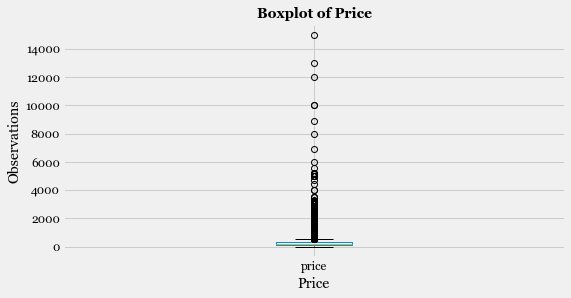

In [174]:
# generate box plot of price
plt.figure(figsize=(8,4))
df.boxplot(column='price')
plt.xlabel('Price')
plt.ylabel('Observations')
plt.title('Boxplot of Price', fontsize=14, fontweight="bold")
plt.show()

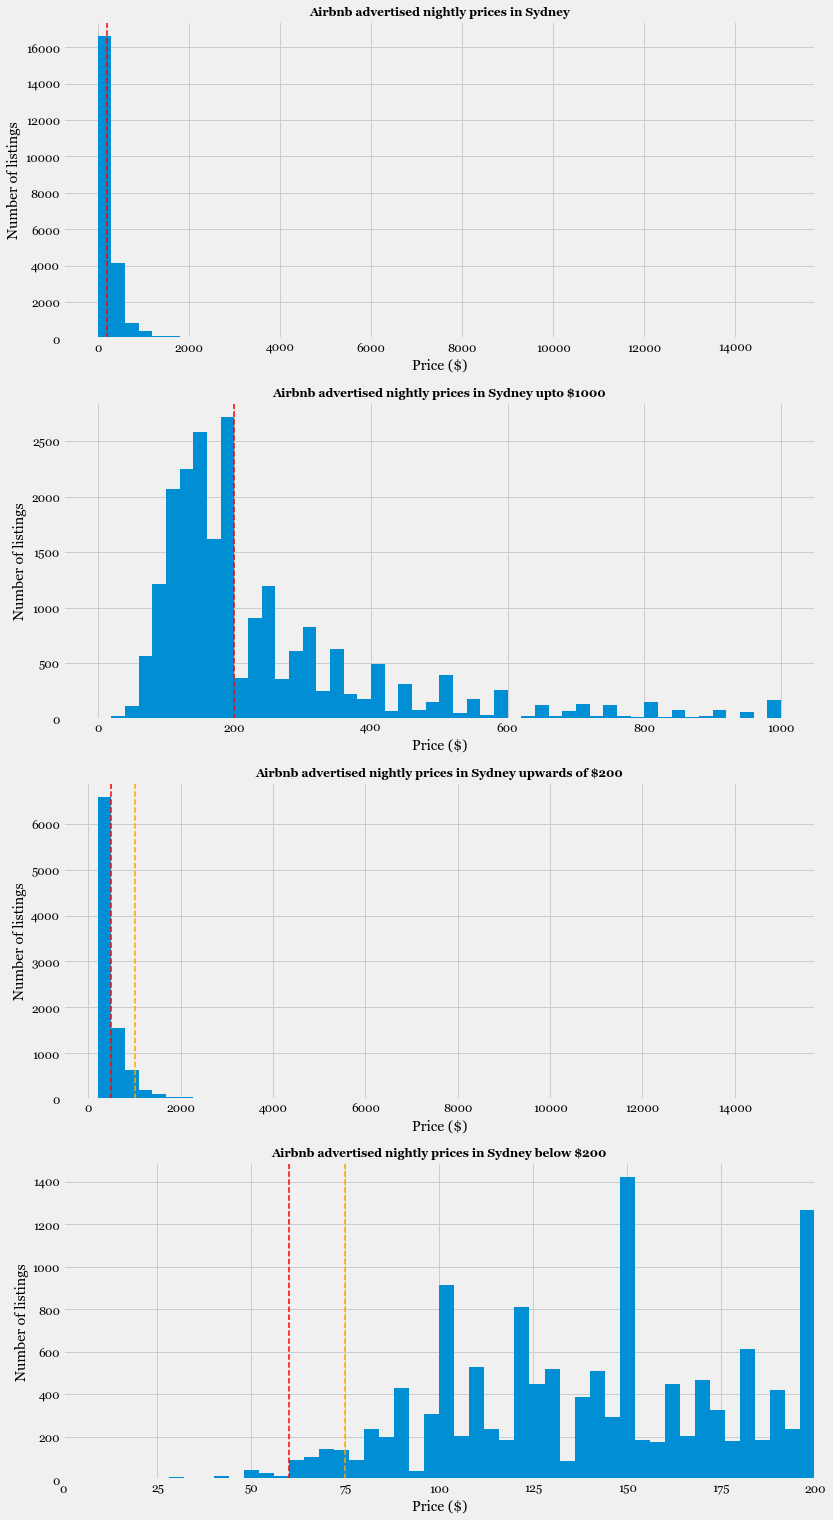

In [175]:
# Distribution of prices
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 25))
plt.margins(x=0)

# all prices
df.price.hist(bins=50, ax=ax[0])
ax[0].axvline(200, color='red', linestyle='--', linewidth=1.5)
ax[0].set_title("Airbnb advertised nightly prices in Sydney", fontsize=12, fontweight="bold")
ax[0].set_xlabel("Price ($)")
ax[0].set_ylabel("Number of listings")

# prices upto $1000
df.price.hist(bins=50, range=(0,1000), ax=ax[1])
ax[1].axvline(200, color='red', linestyle='--', linewidth=1.5)
ax[1].set_title("Airbnb advertised nightly prices in Sydney upto $1000", fontsize=12,fontweight="bold")
ax[1].set_xlabel("Price ($)")
ax[1].set_ylabel("Number of listings")

# prices from $200 upward
df.price.hist(bins=50, range=(200, max(df.price)), ax=ax[2])
ax[2].axvline(500, color='red', linestyle='--', linewidth=1.5)
ax[2].axvline(1000, color='orange', linestyle='--', linewidth=1.5)
ax[2].set_title("Airbnb advertised nightly prices in Sydney upwards of $200", fontsize=12, fontweight="bold")
ax[2].set_xlabel("Price ($)")
ax[2].set_ylabel("Number of listings")

# prices below $200
df.price.hist(bins=50, range=(0, 200), ax=ax[3])
ax[3].axvline(60, color='red', linestyle='--', linewidth=1.5)
ax[3].axvline(75, color='orange', linestyle='--', linewidth=1.5)
ax[3].set_title("Airbnb advertised nightly prices in Sydney below $200", fontsize=12, fontweight="bold")
ax[3].set_xlabel("Price ($)")
ax[3].set_ylabel("Number of listings")

plt.show()

In [176]:
print(f'Observations with price = $0: {df.loc[df.price == 0].shape[0]} or {((df.loc[df.price == 0].shape[0])/len(df))*100:.4f}%')
print(f'Observations with price < $60: {df.loc[df.price < 60].shape[0]} or {((df.loc[df.price < 60].shape[0])/len(df))*100:.4f}%')
print(f'Observations with price > $10,000: {df.loc[df.price >= 10000].shape[0]} or {((df.loc[df.price >= 10000].shape[0])/len(df))*100:.4f}%')
print(f'Observations with price > $5,000: {df.loc[df.price >= 5000].shape[0]} or {((df.loc[df.price >= 5000].shape[0])/len(df))*100:.4f}%')
print(f'Observations with price > $2,000: {df.loc[df.price >= 2000].shape[0]} or {((df.loc[df.price >= 2000].shape[0])/len(df))*100:.4f}%')
print(f'Observations with price > $1,000: {df.loc[df.price >= 1000].shape[0]} or {((df.loc[df.price >= 2000].shape[0])/len(df))*100:.4f}%')
print(f'Observations with price > $500: {df.loc[df.price >= 500].shape[0]} or {((df.loc[df.price >= 2000].shape[0])/len(df))*100:.4f}%')

Observations with price = $0: 4 or 0.0179%
Observations with price < $60: 143 or 0.6385%
Observations with price > $10,000: 5 or 0.0223%
Observations with price > $5,000: 20 or 0.0893%
Observations with price > $2,000: 132 or 0.5894%
Observations with price > $1,000: 509 or 0.5894%
Observations with price > $500: 2576 or 0.5894%


In [177]:
df.loc[df.price == 0.0]

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,latitude,longitude,...,outdoor_space,essentials,host_greeting,hot_water,heating,internet,long_term_stays,private_entrance,self_check_in,accessible
id,,,,,,,,,,,,,,,,,,,,,
20718560,1,5.0,1,100.0,1,3.0,Waterloo,Sydney,-33.899361,151.200712,...,1,1,0,1,0,1,1,0,0,0
21239881,1,2.0,0,94.0,0,1.0,Ultimo,Sydney,-33.882266,151.196702,...,0,1,0,0,1,1,0,1,0,0
21372128,1,4.0,1,99.0,0,40.0,Bondi Beach,Waverley,-33.887442,151.276676,...,0,1,0,1,1,1,1,0,1,0
25960573,1,1.0,0,94.0,0,1.0,Dulwich Hill,Inner West,-33.910858,151.139156,...,0,1,0,0,1,0,0,1,0,0


In [178]:
df.loc[df.price < 60.0].lga.value_counts(normalize=True)

Sydney                  0.167832
Waverley                0.097902
Inner West              0.097902
Randwick                0.076923
Northern Beaches        0.076923
North Sydney            0.048951
Ryde                    0.048951
Bayside                 0.041958
Cumberland              0.041958
Campbelltown            0.041958
Fairfield               0.034965
Parramatta              0.034965
Georges River           0.034965
Canterbury-Bankstown    0.027972
Penrith                 0.020979
Woollahra               0.013986
Hunters Hill            0.013986
Blacktown               0.013986
Burwood                 0.013986
Hornsby Shire           0.013986
Ku-Ring-Gai             0.006993
Canada Bay              0.006993
Hills Shire             0.006993
Liverpool               0.006993
Sutherland Shire        0.006993
Name: lga, dtype: float64

In [179]:
# converting $0 to nan
df.price.replace(0, np.nan, inplace=True)

# filling nan by grouping with lga and bedrooms
df.price.fillna(df.groupby(['lga','bedrooms'])['price'].transform('median'), inplace=True)

In [180]:
# Replacing values under $60 with $60
df.loc[(df.price < 60), 'price'] = 60

# Replacing values over $1000 with $1000
df.loc[df.price > 1000, 'price'] = 1000

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\pandas\plotting\_matplotlib\hist.py:354: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.hist(values, bins=bins, **kwds)


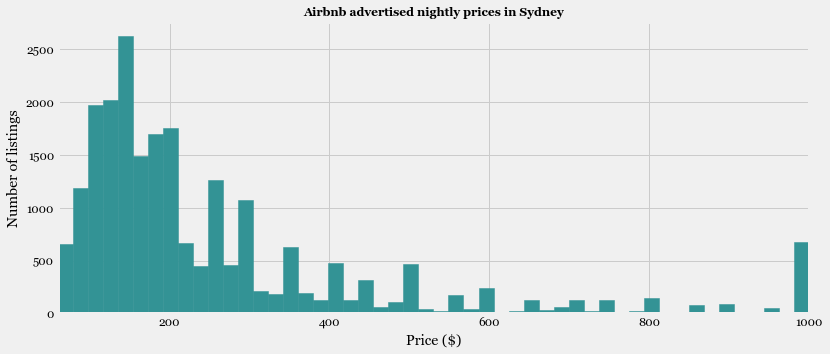

In [181]:
# Final distribution of prices
plt.figure(figsize=(12,5))
df.price.hist(bins=50, COLOR='#339395')
plt.margins(x=0)
plt.title("Airbnb advertised nightly prices in Sydney", fontsize=12, fontweight="bold")
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

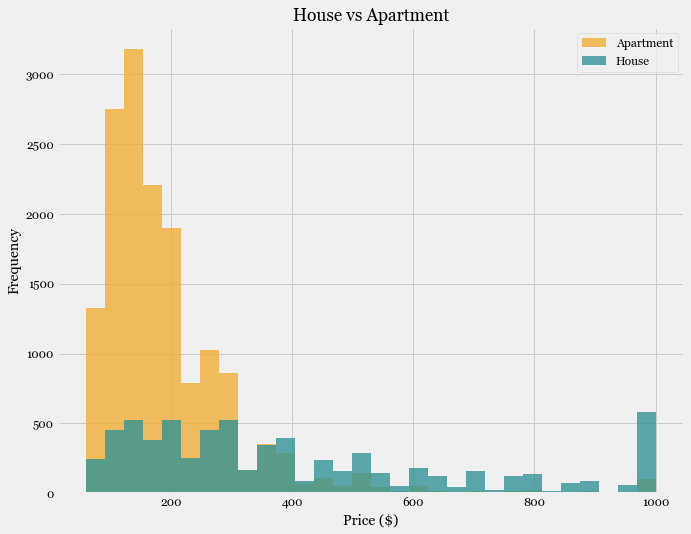

In [182]:
data_house = df[df.property_type == 'House']
data_apt = df[df.property_type == 'Apartment']

plt.figure(figsize=(10,8))

b = plt.hist(data_apt.price, bins=30, alpha=0.8, label='Apartment', color='#efae38')
m = plt.hist(data_house.price, bins=30, alpha=0.8, label='House', color='#339395')

plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('House vs Apartment')
plt.legend()
plt.show()

#### 2. Security deposit
**What is the overall distribution of security prices?**
   * security prices range from \\$0 to \\$7021. 
   * there is a notable drop in security deposit after the \\$5000 mark (first graph), and  just after the \\$1000 (third graph: yellow line). Most notably less than 0.25% or 29 observations are above \\$5000. We will reduce these to \\$5000, since a lot of the observations show > \\$5000 security deposit for prices lower than \\$400 per night.

In [183]:
print(f'Security deposit prices range from: ${min(df.security_deposit)} to ${max(df.security_deposit)}')

Security deposit prices range from: $0.0 to $7021.0


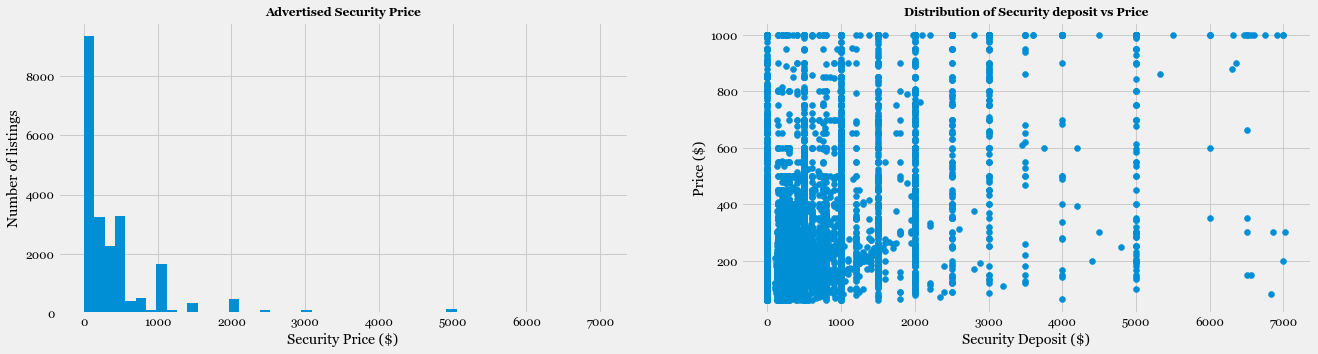

In [184]:
# distribution of security wrt to prices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

df.security_deposit.hist(bins=50, ax=ax[0])
ax[0].set_title("Advertised Security Price", fontsize=12, fontweight="bold")
ax[0].set_xlabel("Security Price ($)")
ax[0].set_ylabel("Number of listings")

plt.scatter(df.security_deposit, df.price)
ax[1].set_title("Distribution of Security deposit vs Price", fontsize=12, fontweight="bold")
ax[1].set_xlabel("Security Deposit ($)")
ax[1].set_ylabel("Price ($)")

plt.show()

In [185]:
print(f'Observations with security deposit $0: {df.loc[df.security_deposit == 0].shape[0]} or {((df.loc[df.security_deposit == 0].shape[0])/len(df))*100:.4f}%')
print(f'Observations with security deposit > $5,000: {df.loc[df.security_deposit > 5000].shape[0]} or {((df.loc[df.security_deposit > 5000].shape[0])/len(df))*100:.4f}%')
print(f'Observations with security deposit > $6,000: {df.loc[df.security_deposit > 6000].shape[0]} or {((df.loc[df.security_deposit > 6000].shape[0])/len(df))*100:.4f}%')

Observations with security deposit $0: 9168 or 40.9359%
Observations with security deposit > $5,000: 29 or 0.1295%
Observations with security deposit > $6,000: 22 or 0.0982%


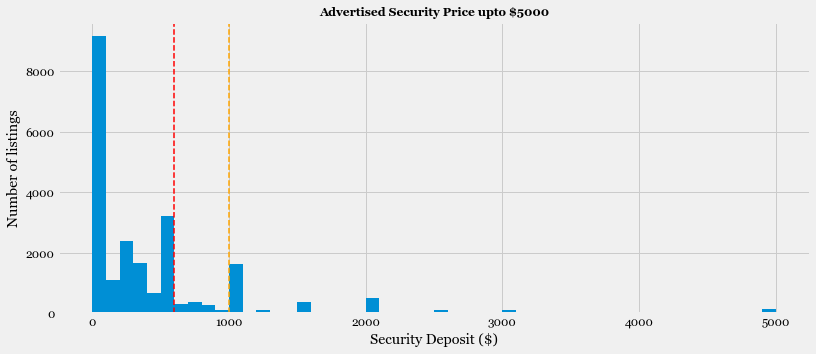

In [186]:
# security prices upto $5000
plt.figure(figsize=(12,5))
df.security_deposit.hist(bins=50, range=(0,5000))
plt.axvline(600, color='red', linestyle='--', linewidth=1.5)
plt.axvline(1000, color='orange', linestyle='--', linewidth=1.5)
plt.title("Advertised Security Price upto $5000", fontsize=12,fontweight="bold")
plt.xlabel("Security Deposit ($)")
plt.ylabel("Number of listings")

plt.show()

In [187]:
# Replacing values over $6000 with $6000
df.loc[df.security_deposit > 5000, 'security_deposit'] = 5000

#### 3. Cleaning Fee
**What is the overall distribution of cleaning fee?**
   * cleaning fee range from \\$0 to \\$1000. 
   * there is a notable drop in cleaning fee after the \\$400 mark (third graph red line) and  after the \\$500 (third graph: yellow line). Most notably less than 0.5% or 96 observations are above \\$500. We will reduce these to \\$500.

In [188]:
print(f'Cleaning Fee prices range from: ${min(df.cleaning_fee)} to ${max(df.cleaning_fee)}')

Cleaning Fee prices range from: $0.0 to $1000.0


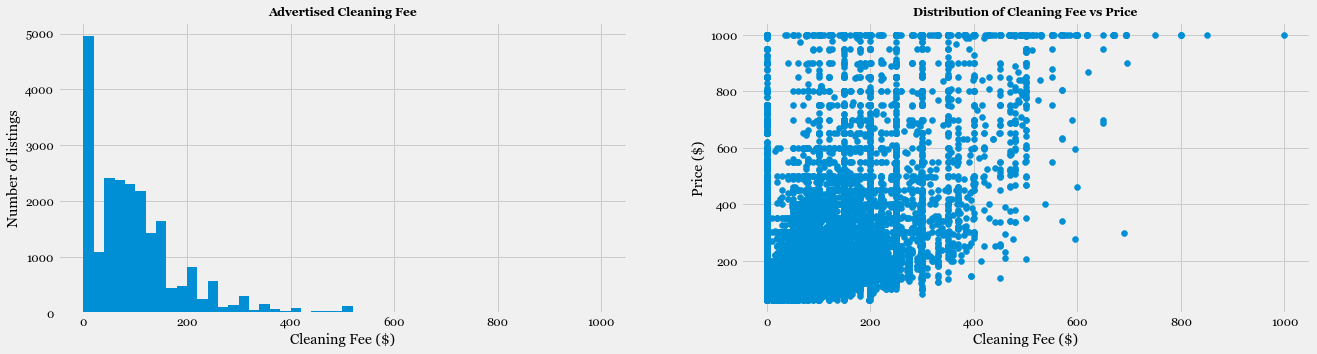

In [189]:
# distribution of cleaning fee wrt to prices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

df.cleaning_fee.hist(bins=50, ax=ax[0])
ax[0].set_title("Advertised Cleaning Fee", fontsize=12, fontweight="bold")
ax[0].set_xlabel("Cleaning Fee ($)")
ax[0].set_ylabel("Number of listings")

plt.scatter(df.cleaning_fee, df.price)
ax[1].set_title("Distribution of Cleaning Fee vs Price", fontsize=12, fontweight="bold")
ax[1].set_xlabel("Cleaning Fee ($)")
ax[1].set_ylabel("Price ($)")

plt.show()

In [190]:
print(f'Observations with cleaning fee $0: {df.loc[df.cleaning_fee == 0].shape[0]} or {((df.loc[df.cleaning_fee == 0].shape[0])/len(df))*100:.6f}%')
print(f'Observations with cleaning fee > $400: {df.loc[df.cleaning_fee > 400].shape[0]} or {((df.loc[df.cleaning_fee > 400].shape[0])/len(df))*100:.6f}%')
print(f'Observations with cleaning fee > $500: {df.loc[df.cleaning_fee > 500].shape[0]} or {((df.loc[df.cleaning_fee > 500].shape[0])/len(df))*100:.6f}%')
print(f'Observations with cleaning fee > $600: {df.loc[df.cleaning_fee > 600].shape[0]} or {((df.loc[df.cleaning_fee > 600].shape[0])/len(df))*100:.6f}%')
print(f'Observations with cleaning fee > $800: {df.loc[df.cleaning_fee > 800].shape[0]} or {((df.loc[df.cleaning_fee > 800].shape[0])/len(df))*100:.6f}%')

Observations with cleaning fee $0: 4821 or 21.526165%
Observations with cleaning fee > $400: 385 or 1.719057%
Observations with cleaning fee > $500: 96 or 0.428648%
Observations with cleaning fee > $600: 32 or 0.142883%
Observations with cleaning fee > $800: 2 or 0.008930%


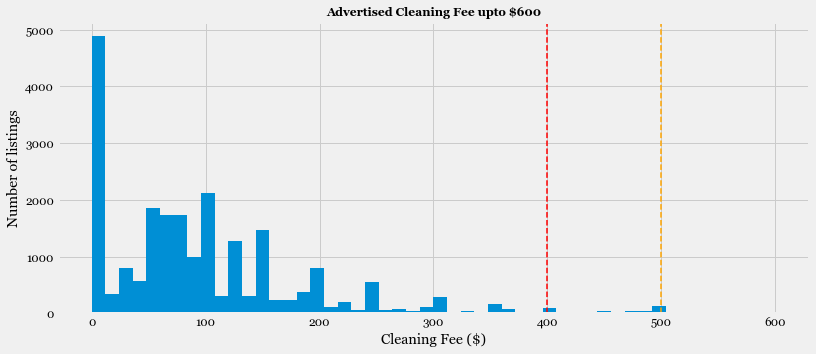

In [191]:
# cleaning fee upto $600
plt.figure(figsize=(12,5))
df.cleaning_fee.hist(bins=50, range=(0,600))
plt.axvline(400, color='red', linestyle='--', linewidth=1.5)
plt.axvline(500, color='orange', linestyle='--', linewidth=1.5)
plt.title("Advertised Cleaning Fee upto $600", fontsize=12,fontweight="bold")
plt.xlabel("Cleaning Fee ($)")
plt.ylabel("Number of listings")

plt.show()

In [192]:
# Replacing values over $500 with $500
df.loc[df.cleaning_fee > 500, 'cleaning_fee'] = 500

In [193]:
df.shape

(22396, 67)

#### 2. Accomodations space
   * **What is the distribution of beds, baths, bedrooms, and people accommodated with respect to price?**
       * as beds and bathrooms increase so does the price
       * as beds increase so does the price, but have diminishing returns after 10 beds
       * the median common setup is 2 beds in 2 bedroom, with 1 bathroom that accommodates 4 guests. Not surprisingly, properties that accommodate more people achieve higher rates, with diminishing returns after about 12 people.

In [194]:
print(f'''Bedrooms range from: {min(df.bedrooms)} to {max(df.bedrooms)} with {df.bedrooms.median()} median bedrooms.
Beds range from: {min(df.beds)} to {max(df.beds)} with {df.beds.median()} median beds.
Bathrooms range from: {min(df.bathrooms)} to {max(df.bathrooms)} with {df.bathrooms.median()} median bathrooms.
Number of guests range from: {min(df.accommodates)} to {max(df.accommodates)} with {df.accommodates.median()} median guests accommodated.
Number of guested included in the price range from: {min(df.guests_included)} to {max(df.guests_included)} with {df.guests_included.median()} median guests included in price''')

Bedrooms range from: 1 to 10 with 2.0 median bedrooms.
Beds range from: 1 to 16 with 2.0 median beds.
Bathrooms range from: 1.0 to 8.0 with 1.0 median bathrooms.
Number of guests range from: 1 to 16 with 4.0 median guests accommodated.
Number of guested included in the price range from: 1 to 70 with 1.0 median guests included in price


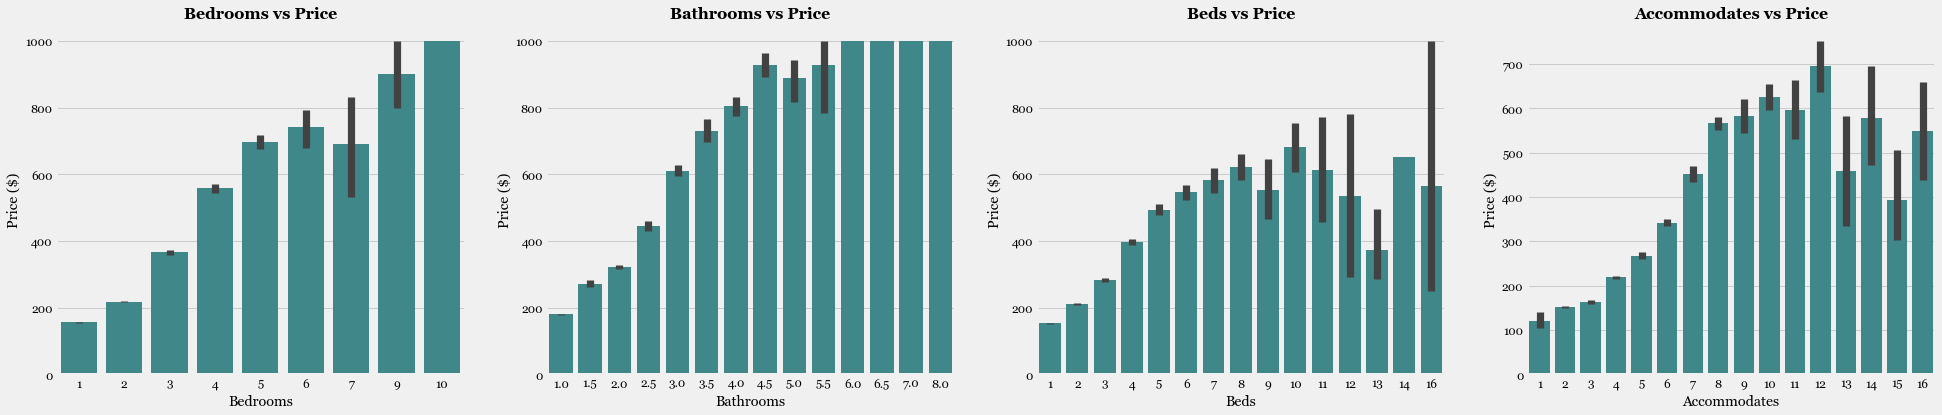

In [195]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 6))
plt.margins(x=0)

# bedrooms
sns.barplot(data=df, x='bedrooms', y='price', color='#339395', ax=ax[0])
ax[0].set_title("Bedrooms vs Price", fontsize=16, fontweight="bold")
ax[0].set_xlabel("Bedrooms")
ax[0].set_ylabel("Price ($)")

# bathrooms
sns.barplot(data=df, x='bathrooms', y='price', color='#339395', ax=ax[1])
ax[1].set_title("Bathrooms vs Price", fontsize=16, fontweight="bold")
ax[1].set_xlabel("Bathrooms")
ax[1].set_ylabel("Price ($)")

# beds
sns.barplot(data=df, x='beds', y='price', color='#339395', ax=ax[2])
ax[2].set_title("Beds vs Price", fontsize=16, fontweight="bold")
ax[2].set_xlabel("Beds")
ax[2].set_ylabel("Price ($)")

# beds
sns.barplot(data=df, x='accommodates', y='price', color='#339395', ax=ax[3])
ax[3].set_title("Accommodates vs Price", fontsize=16, fontweight="bold")
ax[3].set_xlabel("Accommodates")
ax[3].set_ylabel("Price ($)")

plt.show()

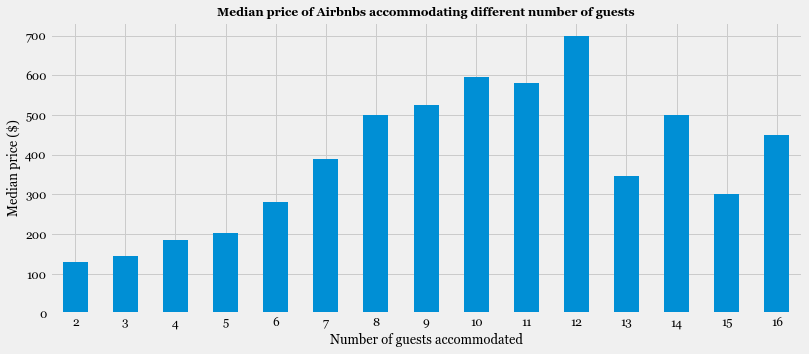

In [196]:
# Accommodates vs Price
plt.figure(figsize=(12,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=12, fontweight="bold")
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

<Figure size 1800x1800 with 0 Axes>

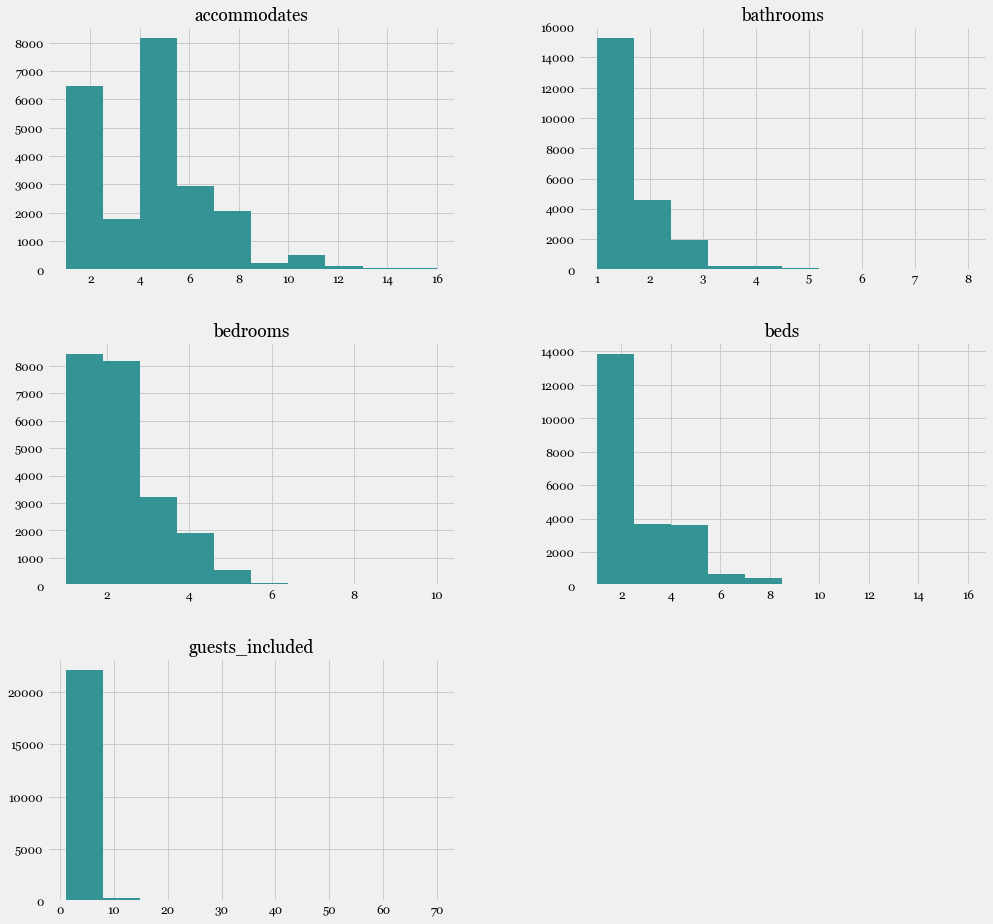

In [197]:
# Distribution of Accommodates, Beds, Bathrooms, and Bedrooms
plt.figure(figsize=(25,25))
df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included']].hist(figsize=(15,15), color='#339395')
plt.show()

#### 3. About host
   * **What can we tell about the hosts listings and experiences?**
       * Median listing per is 1, while the average is much higher at 12 listings per host.
       * More than half the listings are from hosts with 1 listing
       * There is not much difference between number of years that a host has been on the platform and price, although hosts with 9 years experience on average command the highest price
       * On average hosts with 3-6 years on the platforms have the most number of listings

<AxesSubplot:xlabel='host_experience', ylabel='price'>

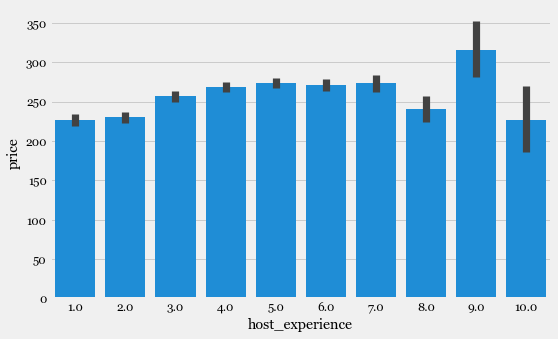

In [198]:
# Number of listing vs experience

plt.figure(figsize=(8,5))
sns.barplot(data=df, x='host_experience', y='price', color='#0093f5')

In [199]:
print(f'''Median number of listings per host:{int(df.host_listings.median())}.
Mean number of listings per host:{int(round(df.host_listings.mean()))}.
Hosts with 1 listing: {int(round(100*len(df[df.host_listings == 1])/len(df)))}%.''')

Median number of listings per host:1.
Mean number of listings per host:12.
Hosts with 1 listing: 62%.


Text(0, 0.5, 'Number of listings')

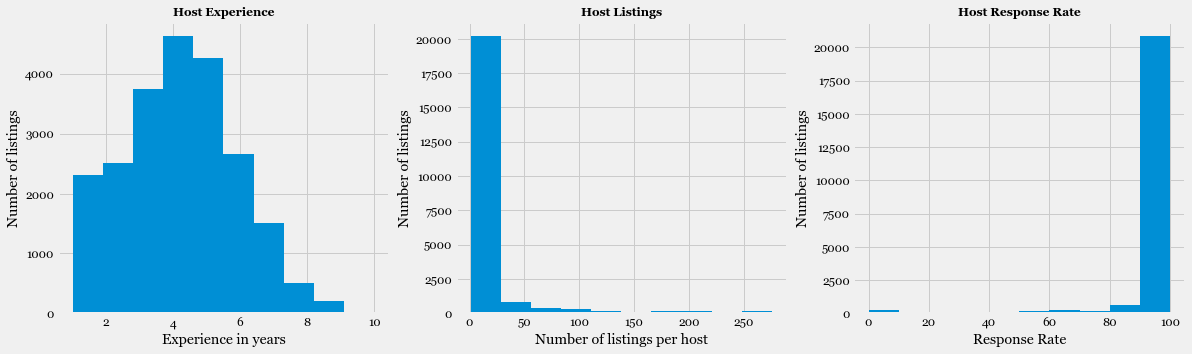

In [200]:
# Distribution of listings
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# experience
df.host_experience.hist(bins=10, ax=ax[0])
ax[0].set_title("Host Experience", fontsize=12, fontweight="bold")
ax[0].set_xlabel("Experience in years")
ax[0].set_ylabel("Number of listings")

# listings
df.host_listings.hist(bins=10, ax=ax[1])
ax[1].set_title("Host Listings", fontsize=12,fontweight="bold")
ax[1].set_xlabel("Number of listings per host")
ax[1].set_ylabel("Number of listings")

# response rate
df.response_rate.hist(bins=10, ax=ax[2])
ax[2].set_title("Host Response Rate", fontsize=12,fontweight="bold")
ax[2].set_xlabel("Response Rate")
ax[2].set_ylabel("Number of listings")

#### 4. Neighbourhood Characteristics
   * **What can we tell about the neighbourhood characteristics?**
       * most of the observations are within 10kms of the CBD (rating 2 = 10km or less).
       * most of the observations have a 5 star cafe density rating
       * transport infrastructure generally ranges between 2 - 4 stars
       * most observations are within 4kms of the beach; range from 4-5 stars
       * most observations are more than 8kms from national parks and nature trails (1star)
       * many observations are within 2kms of cultural destinations such as museums, theatres, and shopping,etc. with an equal amount within 4-6kms from such destinations (median 3 stars=6km or less)

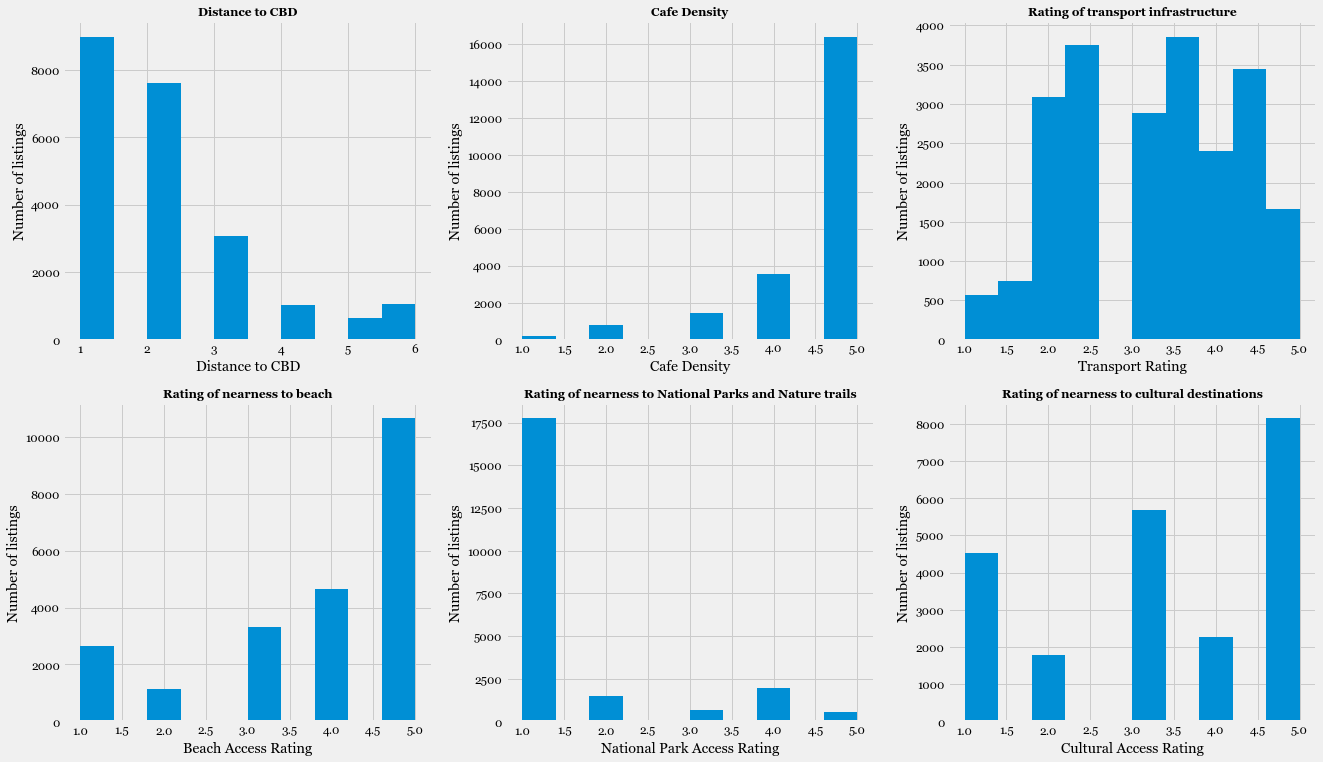

In [201]:
# Distribution of neighbourhood characteristics
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# dist_to_cbd
df.dist_to_cbd.hist(bins=10, ax=ax[0, 0])
ax[0, 0].set_title("Distance to CBD", fontsize=12, fontweight="bold")
ax[0, 0].set_xlabel("Distance to CBD")
ax[0, 0].set_ylabel("Number of listings")

# cafe_density
df.cafe_density.hist(bins=10, ax=ax[0, 1])
ax[0, 1].set_title("Cafe Density", fontsize=12,fontweight="bold")
ax[0, 1].set_xlabel("Cafe Density")
ax[0, 1].set_ylabel("Number of listings")

# transport_rating
df.transport_rating.hist(bins=10, ax=ax[0, 2])
ax[0, 2].set_title("Rating of transport infrastructure", fontsize=12,fontweight="bold")
ax[0, 2].set_xlabel("Transport Rating")
ax[0, 2].set_ylabel("Number of listings")

# beach_access
df.beach_access.hist(bins=10, ax=ax[1, 0])
ax[1, 0].set_title("Rating of nearness to beach", fontsize=12,fontweight="bold")
ax[1, 0].set_xlabel("Beach Access Rating")
ax[1, 0].set_ylabel("Number of listings")

# nat_park_access
df.nat_park_access.hist(bins=10, ax=ax[1, 1])
ax[1, 1].set_title("Rating of nearness to National Parks and Nature trails", fontsize=12,fontweight="bold")
ax[1, 1].set_xlabel("National Park Access Rating")
ax[1, 1].set_ylabel("Number of listings")

# cultural_access
df.cultural_access.hist(bins=10, ax=ax[1, 2])
ax[1, 2].set_title("Rating of nearness to cultural destinations", fontsize=12,fontweight="bold")
ax[1, 2].set_xlabel("Cultural Access Rating")
ax[1, 2].set_ylabel("Number of listings")

plt.show()

In [202]:
print(f'''Median distance from CBD:{(df.dist_to_cbd.median())}.
Median cafe density rating:{(df.cafe_density.median())}.
Median transport rating:{(df.transport_rating.median())}.
Median beach access rating:{(df.beach_access.median())}.
Median national park access rating:{(df.nat_park_access.median())}.
Median cultural access rating:{(df.cultural_access.median())}.''')

Median distance from CBD:2.0.
Median cafe density rating:5.0.
Median transport rating:3.5.
Median beach access rating:4.0.
Median national park access rating:1.0.
Median cultural access rating:3.0.


#### 5. Reviews & Ratings
   * **What is the distribution of reviews like?**
       * There are more number of reviews for listings at prices less than \\$400.
       * Majority of the review categories have a rating of 10/10.
       * Ratings of less than 8 are very rare.
       * Keep in mind that 0 is no reviews yet.

In [203]:
print(f'''Number of reviews range from: {min(df.number_of_reviews)} to {max(df.number_of_reviews)} with {df.number_of_reviews.median()} median reviews.
Review scores rating range from: {min(df.review_scores_rating)} to {max(df.review_scores_rating)} with {df.review_scores_rating.median()} median rating out of 100.
Accuracy scores range from: {min(df.review_scores_accuracy)} to {max(df.review_scores_accuracy)} with {df.review_scores_accuracy.median()} median score out of 10.
Cleanliness scores range from: {min(df.review_scores_cleanliness)} to {max(df.review_scores_cleanliness)} with {df.review_scores_cleanliness.median()} median score out of 10.
Checkin scores range from: {min(df.review_scores_checkin)} to {max(df.review_scores_checkin)} with {df.review_scores_checkin.median()} median score out of 10.
Communication scores range from: {min(df.review_scores_communication)} to {max(df.review_scores_communication)} with {df.review_scores_communication.median()} median score out of 10.
Location scores range from: {min(df.review_scores_location)} to {max(df.review_scores_location)} with {df.review_scores_location.median()} median score out of 10.
Value scores range from: {min(df.review_scores_value)} to {max(df.review_scores_value)} with {df.review_scores_value.median()} median score out of 10.''')

Number of reviews range from: 0 to 443 with 2.0 median reviews.
Review scores rating range from: 0 to 100 with 92.0 median rating out of 100.
Accuracy scores range from: 0 to 10 with 10.0 median score out of 10.
Cleanliness scores range from: 0 to 10 with 9.0 median score out of 10.
Checkin scores range from: 0 to 10 with 10.0 median score out of 10.
Communication scores range from: 0 to 10 with 10.0 median score out of 10.
Location scores range from: 0 to 10 with 10.0 median score out of 10.
Value scores range from: 0 to 10 with 9.0 median score out of 10.


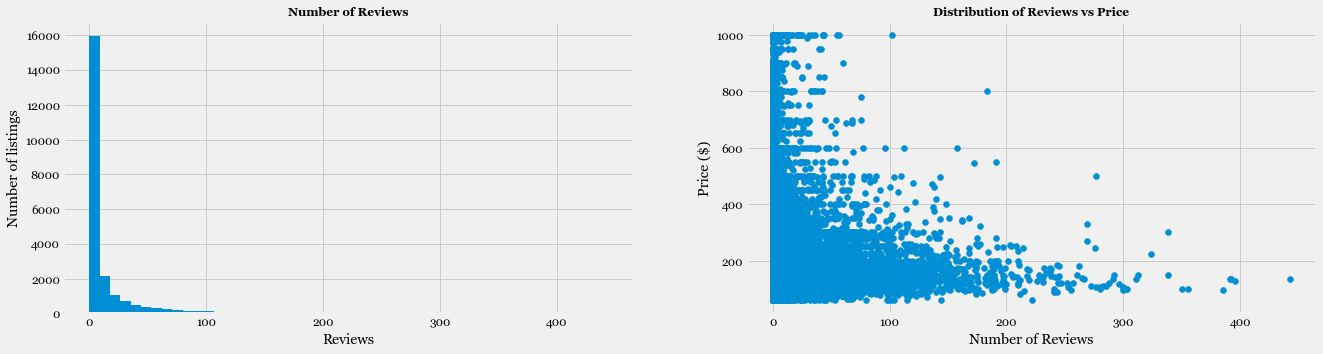

In [204]:
# distribution of number of reviews wrt to prices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

df.number_of_reviews.hist(bins=50, ax=ax[0])
ax[0].set_title("Number of Reviews", fontsize=12, fontweight="bold")
ax[0].set_xlabel("Reviews")
ax[0].set_ylabel("Number of listings")

plt.scatter(df.number_of_reviews, df.price)
ax[1].set_title("Distribution of Reviews vs Price", fontsize=12, fontweight="bold")
ax[1].set_xlabel("Number of Reviews")
ax[1].set_ylabel("Price ($)")

plt.show()

<Figure size 1800x1800 with 0 Axes>

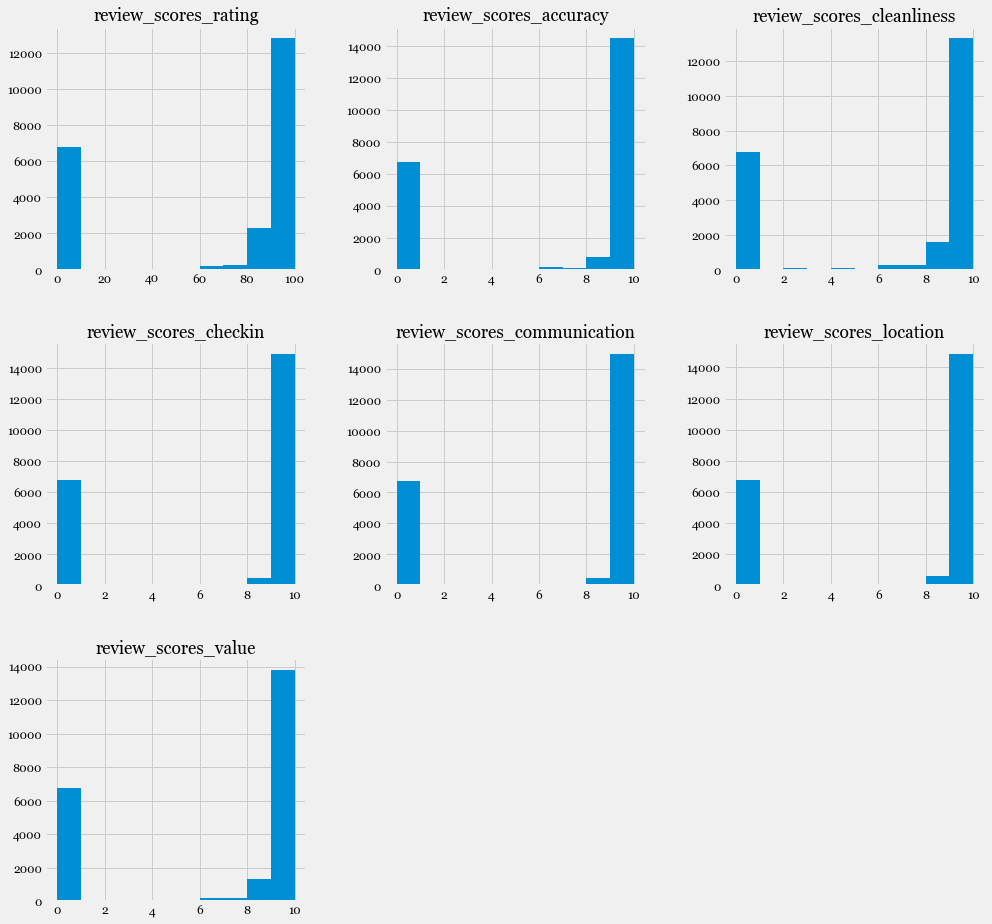

In [205]:
# Distribution of Review scores
plt.figure(figsize=(25,25))
df[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']].hist(figsize=(15,15))
plt.show()

### 6. Minimum Nights
* **What is the distribution for minimum and maximum nights?**
    * for a short-term rental platform 1000 min nights value is either a mistake or one of the speculative listings.
    * outliers here begin after 15 days. Only 2% of observations have min nights above 30 days & only about 4% have min nights above 15 days.
    * We will change all nights above 15 days to 15 to keep it realistic.

In [206]:
print(f'''
Minimum nights Median: {df.min_nights.median()}
Minimum nights Mean: {df.min_nights.mean()}
Minimum nights min value: {df.min_nights.min()}
Minimum nights max value: {df.min_nights.max()}''')


Minimum nights Median: 3.0
Minimum nights Mean: 5.5681371673513125
Minimum nights min value: 1
Minimum nights max value: 1000


In [207]:
print(f'Observations with minimum nights 1: {df.loc[df.min_nights == 1].shape[0]} or {((df.loc[df.min_nights == 1].shape[0])/len(df))*100:.6f}%')
print(f'Observations with minimum nights > 15: {df.loc[df.min_nights > 15].shape[0]} or {((df.loc[df.min_nights > 15].shape[0])/len(df))*100:.6f}%')
print(f'Observations with minimum nights > 30: {df.loc[df.min_nights > 30].shape[0]} or {((df.loc[df.min_nights > 30].shape[0])/len(df))*100:.6f}%')
print(f'Observations with minimum nights > 180: {df.loc[df.min_nights > 180].shape[0]} or {((df.loc[df.min_nights > 180].shape[0])/len(df))*100:.6f}%')

Observations with minimum nights 1: 3874 or 17.297732%
Observations with minimum nights > 15: 833 or 3.719414%
Observations with minimum nights > 30: 428 or 1.911056%
Observations with minimum nights > 180: 18 or 0.080371%


Text(0, 0.5, 'Number of listings')

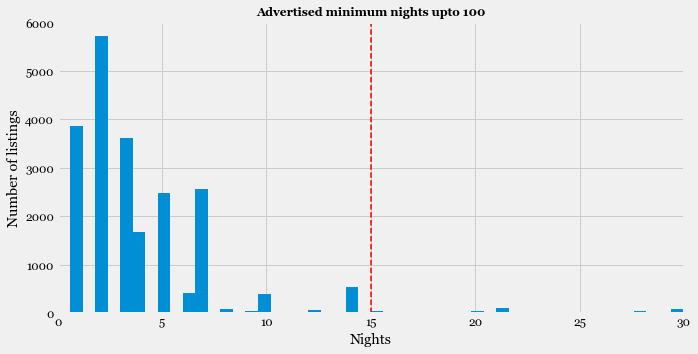

In [208]:
# Distribution of min nights
fig, ax = plt.subplots(figsize=(10, 5))
plt.margins(x=0)

# min nights
df.min_nights.hist(bins=50, range=(0,30))
plt.axvline(15, color='red', linestyle='--', linewidth=1.5)
plt.title("Advertised minimum nights upto 100", fontsize=12, fontweight="bold")
plt.xlabel("Nights")
plt.ylabel("Number of listings")

In [209]:
# Replacing values over 15
df.loc[df.min_nights > 15, 'min_nights'] = 15

   * **Maximum_nights: maximum value of max nights as 10000 days is not realistic.**
       * more than 50% of observations have max nights above 180 days.
       * keeping in line with our 180 day cap we could change all values above 180 days to 180 days.

In [210]:
print(f'''
Maximum nights Median: {bnb_data.max_nights.median()}
Maximum nights Mean: {bnb_data.max_nights.mean()}
Maximum nights min value: {bnb_data.max_nights.min()}
Maximum nights max value: {bnb_data.max_nights.max()}''')


Maximum nights Median: 1125.0
Maximum nights Mean: 682.3063493480979
Maximum nights min value: 1
Maximum nights max value: 10000


In [211]:
print(f'Observations with maximum nights 1: {df.loc[df.max_nights == 1].shape[0]} or {((df.loc[df.max_nights == 1].shape[0])/len(df))*100:.6f}%')
print(f'Observations with maximum nights > 180: {df.loc[df.max_nights > 180].shape[0]} or {((df.loc[df.max_nights > 180].shape[0])/len(df))*100:.6f}%')

Observations with maximum nights 1: 10 or 0.044651%
Observations with maximum nights > 180: 13767 or 61.470798%


Text(0, 0.5, 'Number of listings')

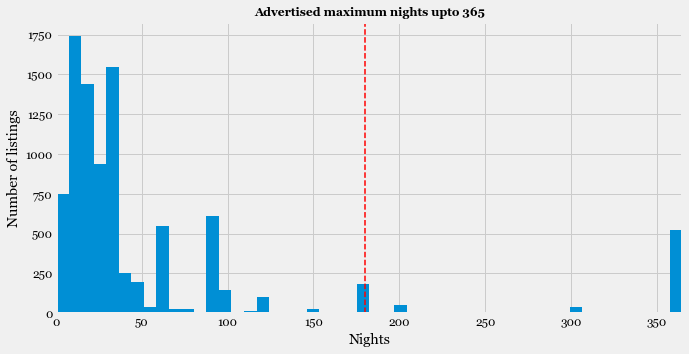

In [212]:
# Distribution of max nights
fig, ax = plt.subplots(figsize=(10, 5))
plt.margins(x=0)

# min nights
df.max_nights.hist(bins=50, range=(0,365))
plt.axvline(180, color='red', linestyle='--', linewidth=1.5)
plt.title("Advertised maximum nights upto 365", fontsize=12, fontweight="bold")
plt.xlabel("Nights")
plt.ylabel("Number of listings")

In [213]:
# Replacing values over 15
df.loc[df.max_nights > 180, 'max_nights'] = 180

### B. Categorical Features
#### 1. Neighbourhood
**How are the listings distributed geographically and what is the price distribution?**
   * The LGA's of Sydney, Northern Beaches, and Waverley make the top 3 LGA's with the most listing. This is unsurprising, since these are the most accessible to tourist and cultural destinations and the famous Sydney beaches. 
   * The top suburbs are the beach suburbs of Bondi Beach and Manly followed by the Sydney suburb of Surrey Hills-central location for both cultural and beach access.
   * Unsurprisingly, the most pricey LGA's are the beach LGA's of Mosman and Northern Beaches alongside Hunter's Hill - a not so centrally located but is considered one of the elite suburbs of Sydney with riverviews.

<AxesSubplot:>

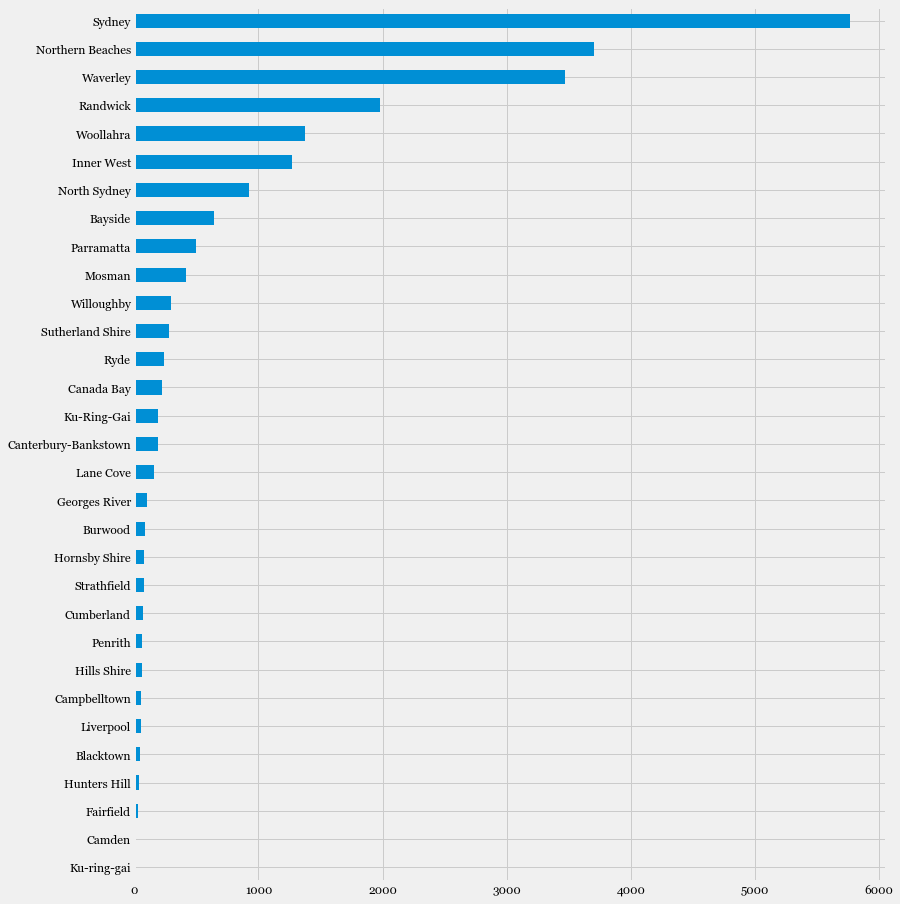

In [214]:
df.lga.value_counts().sort_values().plot(kind='barh', figsize=(12, 15))

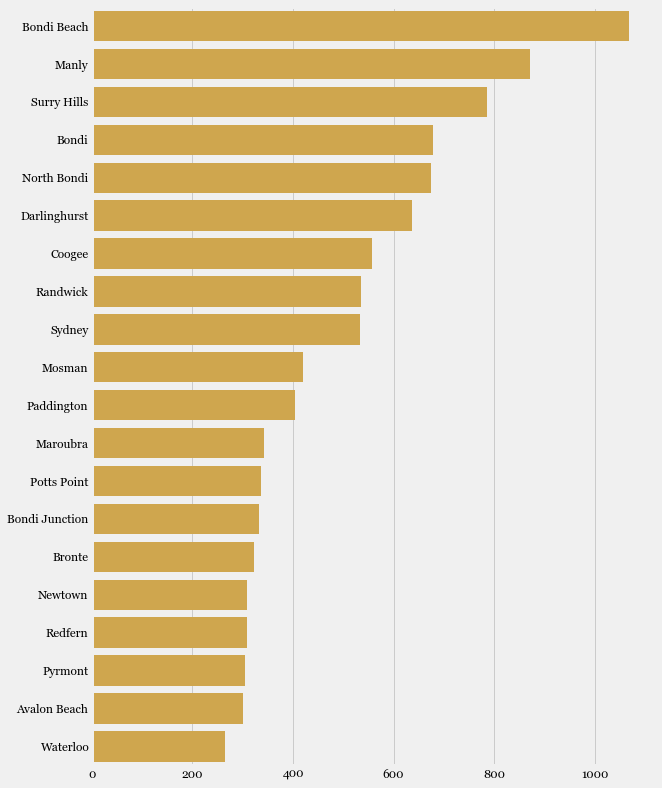

In [215]:
plt.figure(figsize=(9,13))
suburb_count = df.suburb.value_counts()
suburb_count = suburb_count[:20]
suburb_count1 = sns.barplot(x= suburb_count.values, y=suburb_count.index, color='#e5ae38')

<AxesSubplot:xlabel='price', ylabel='lga'>

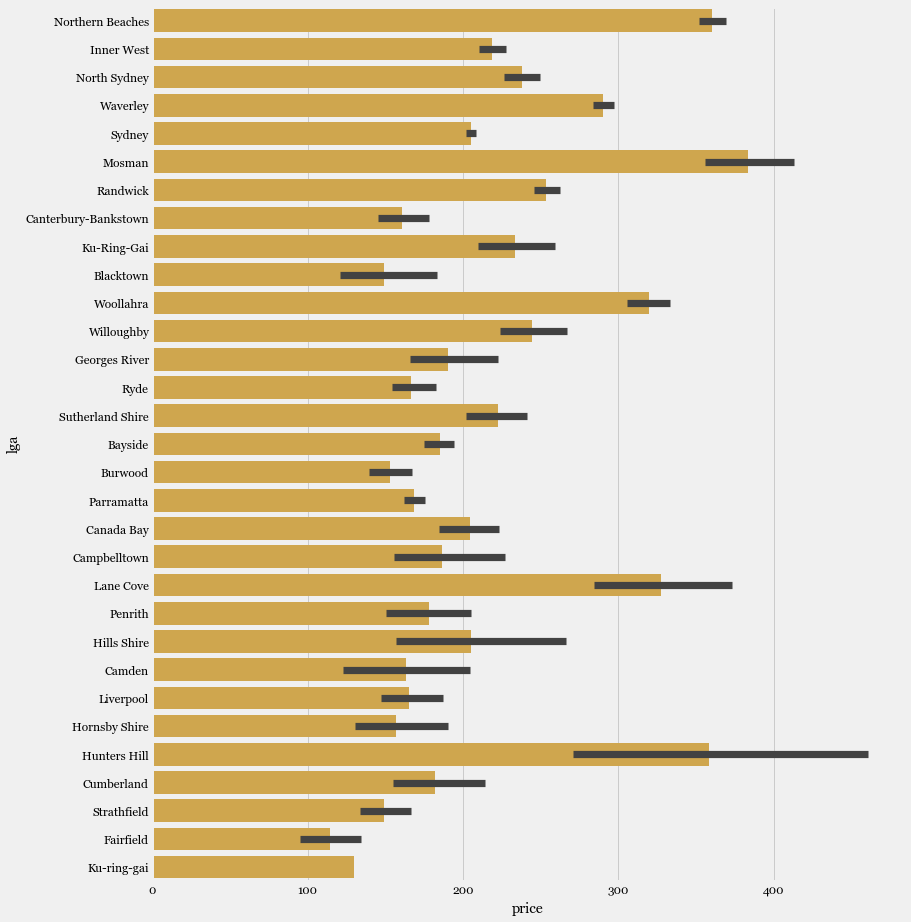

In [216]:
plt.figure(figsize=(12,15))
sns.barplot(data=df, x='price', y='lga', color='#e5ae38')

### 2. Property Type
* **What is the most common property type?**
    * Almost 70% of the listings are of apartments
    * While homes make up only 30% of the listings, they command more than double the price. This is not surprising since all the listings are for entire homes, which tend to be larger than apartments.

In [217]:
df.property_type.value_counts(normalize=True)

Apartment    0.694901
House        0.305099
Name: property_type, dtype: float64

<AxesSubplot:>

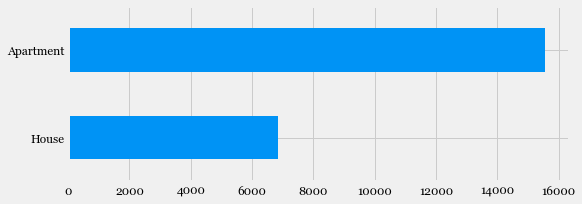

In [218]:
df.property_type.value_counts().sort_values().plot(kind='barh', figsize=(8, 3), color='#0093f5')

<AxesSubplot:xlabel='price', ylabel='property_type'>

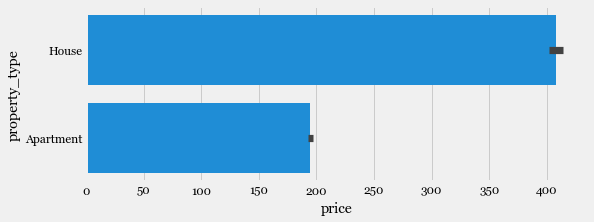

In [219]:
plt.figure(figsize=(8,3))
sns.barplot(data=df, x='price', y='property_type', color='#0093f5')

### C. Binary Features

In [220]:
def binary_price_plot(col, figsize=(8,3)):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['#e5ae38', '#0093f5'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['#e5ae38', '#0093f5'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)')
    ax2.set_xlabel('')
    
    plt.show()

#### 1. Host Location
* **Does being a local host matter?**
    * Location of the host, whether local or international, doesn't seem to make much difference with very little difference between the median price commanded by the two. Infact one can argue that showing an international presence makes a positive impact on potential guests

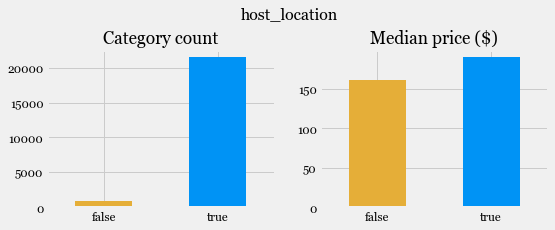

1    0.960439
0    0.039561
Name: host_location, dtype: float64


In [221]:
binary_price_plot('host_location')
print(df.host_location.value_counts(normalize=True))

### 2. Superhosts
* **Is it worth being a superhost?**
    * Only about 13% of hosts are superhosts. However, it does not seem to improve the median price per night of their listings, so it is arguable whether or not it is worth it from a purely time & finance perspective.

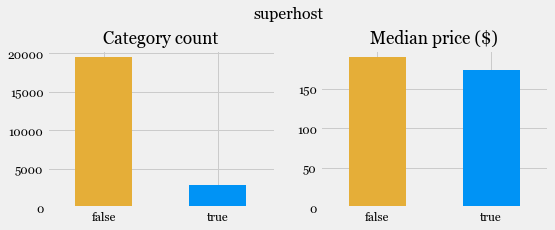

0    0.870379
1    0.129621
Name: superhost, dtype: float64


In [222]:
binary_price_plot('superhost')
print(df.superhost.value_counts(normalize=True))

#### 3. Host response time
* **Does it matter if you don't respond within a day?**
    * There seems to be no difference in the median price commanded based on a faster response time.

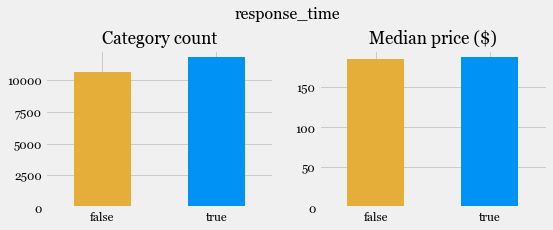

1    0.526076
0    0.473924
Name: response_time, dtype: float64


In [223]:
binary_price_plot('response_time')
print(df.response_time.value_counts(normalize=True))

#### 4. Cancellation policy
* **Does a not-strict/flexible cancellation policy have better a better outlook?**
    * Having a more flexible cancellation policy doesn't seem to have a better effect on median pricing. Hosts with varying degrees of strict policies have a better outcome.

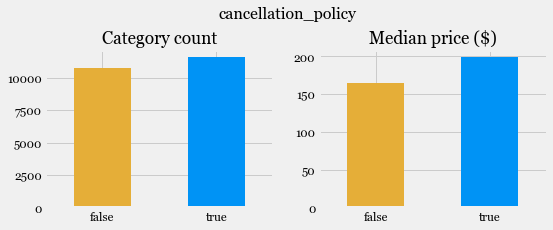

1    0.518441
0    0.481559
Name: cancellation_policy, dtype: float64


In [224]:
binary_price_plot('cancellation_policy')
print(df.cancellation_policy.value_counts(normalize=True))

#### 5. Guest verifications
* **Does having a more lenient guest verification outlook result in better pricing?**
    * These categories have negligible True values.
    * There is no difference in the median prices between the two.
    * These categories can be removed.

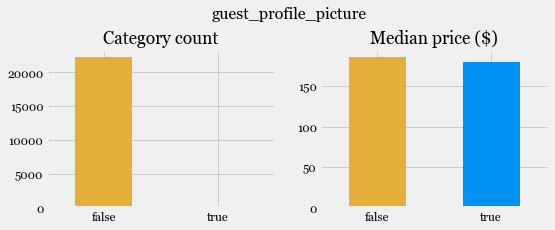

0    0.994195
1    0.005805
Name: guest_profile_picture, dtype: float64


In [225]:
binary_price_plot('guest_profile_picture')
print(df.guest_profile_picture.value_counts(normalize=True))

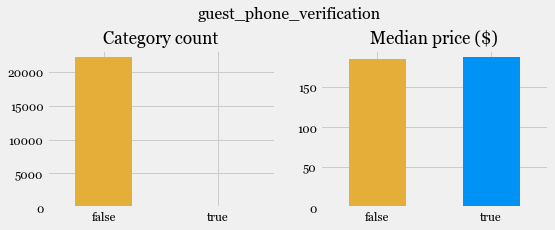

0    0.991874
1    0.008126
Name: guest_phone_verification, dtype: float64


In [226]:
binary_price_plot('guest_phone_verification')
print(df.guest_phone_verification.value_counts(normalize=True))

#### 6. Instant booking
* **How many listings are instant bookable (i.e. booked without messaging the host first), and is it worth it?**
    * Only about 39% of listings can be booked instantly. However, the added convenience doesn't seem to have a better lotcome for the hosts.

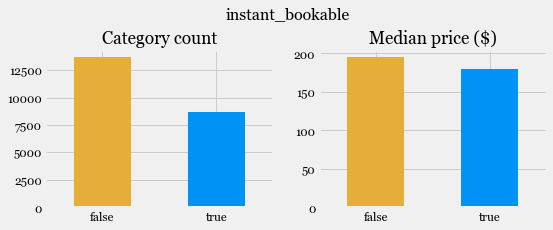

0    0.610868
1    0.389132
Name: instant_bookable, dtype: float64


In [227]:
binary_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

In [228]:
# drop guests verification features
df.drop(['guest_profile_picture', 'guest_phone_verification'], axis=1, inplace=True)

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 65 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_location                22396 non-null  int64  
 1   host_experience              22396 non-null  float64
 2   response_time                22396 non-null  int64  
 3   response_rate                22396 non-null  float64
 4   superhost                    22396 non-null  int64  
 5   host_listings                22396 non-null  float64
 6   suburb                       22396 non-null  object 
 7   lga                          22396 non-null  object 
 8   latitude                     22396 non-null  float64
 9   longitude                    22396 non-null  float64
 10  dist_to_cbd                  22396 non-null  float64
 11  cafe_density                 22396 non-null  float64
 12  transport_rating             22396 non-null  float64
 13  beach_acc

#### Amenities
* **Which amenities are the most common, and which increases the price of listings?**
    * Most of these can be split into 4 main types:
    * **1. Most common with higher median price**
        * air conditioning | hi-fi electronics | child friendly | cooking basics | parking | white goods | heating | internet
    * **2. Uncommon with higher median price**
        * tub/sauna/pool | barbeque | bath essentials | pets allowed | coffee machine | outdoor space
    * **3. No major difference in price, with or without it**
        * breakfast | balcony | essentials | host greeting | hot water | private entrance | self check-in | accessible | long term stay | bed linens
    * **4. Uncommon with lower median price**
        * elevator
        
    * Properties with luxury bathrooms with sauna and pools can get a high premium price on short term listings.
    * Other staple such as outdoor areas and barbeque areas also command higher prices
    * Being able to allow pets is indeed a luxury with high prices
    * there is often not a simple causative relationship - a parking space might improve your price, but listings with parking spaces are cheaper on average because they are less likely to be in central locations, and location is a more important factor than parking space

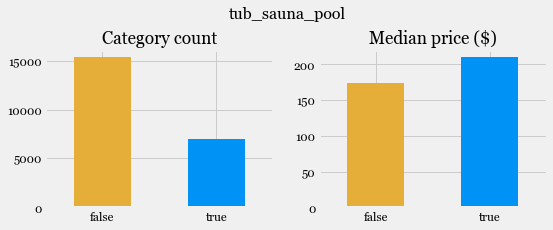

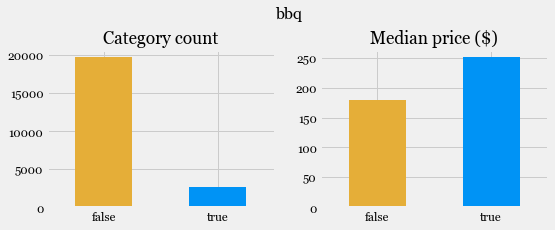

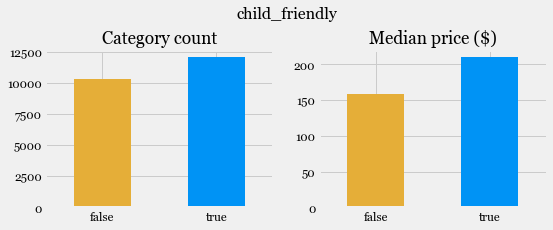

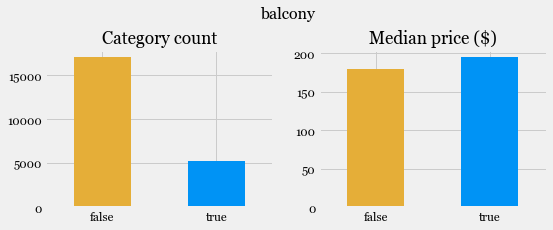

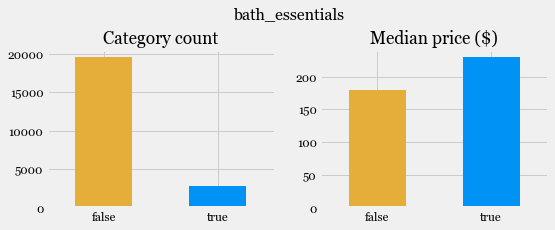

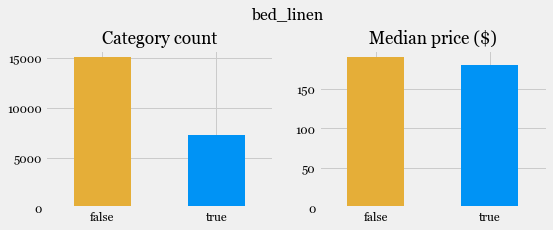

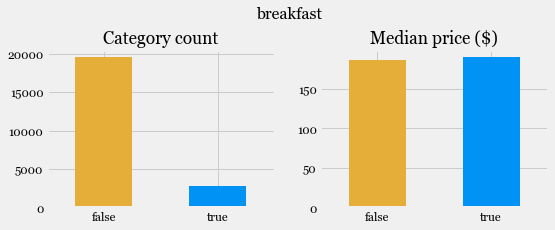

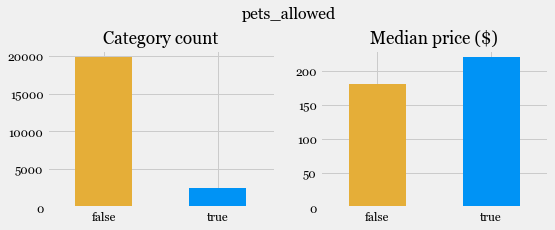

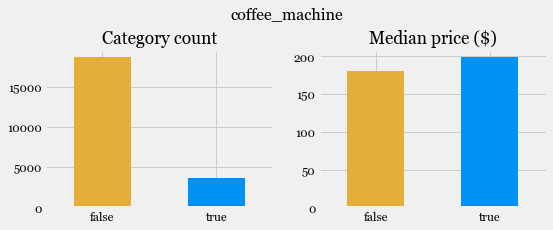

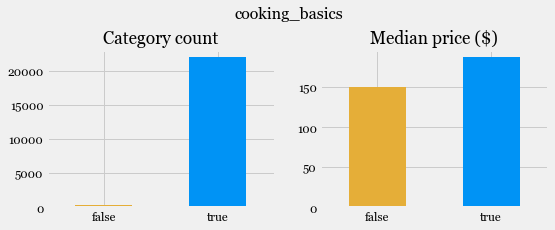

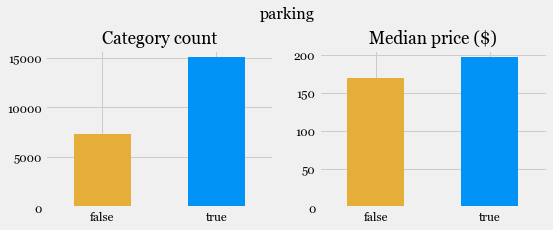

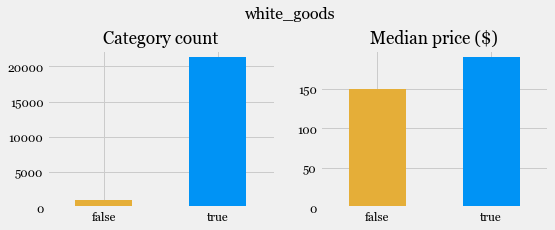

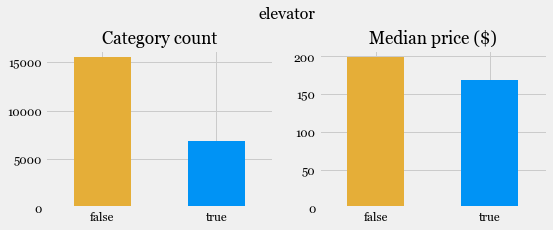

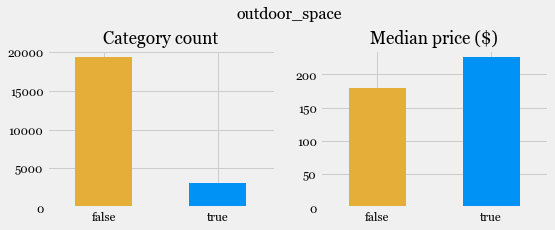

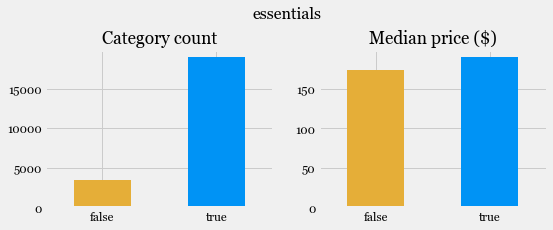

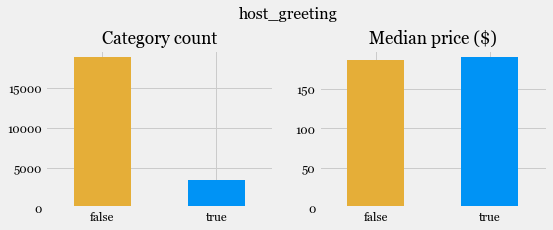

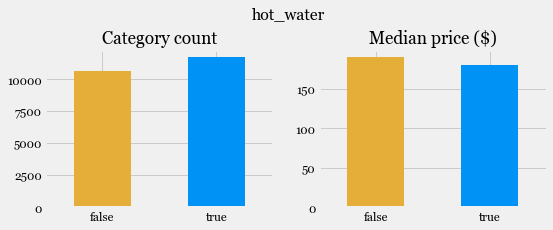

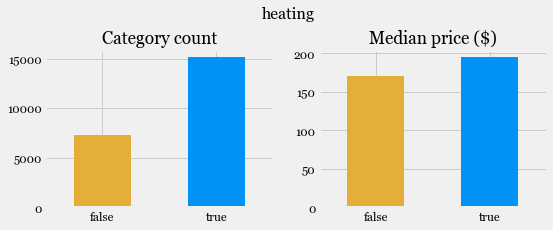

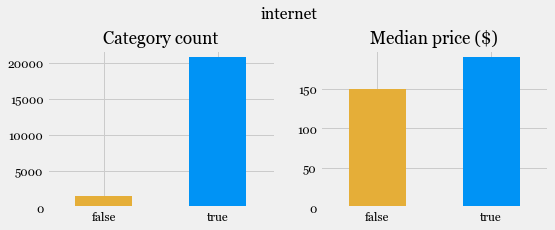

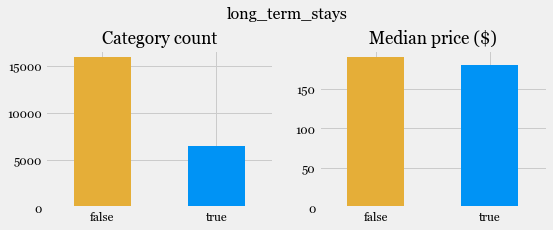

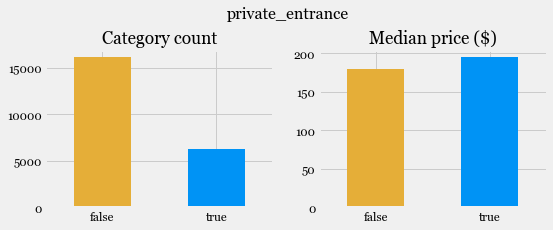

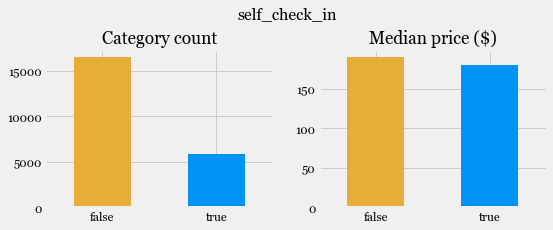

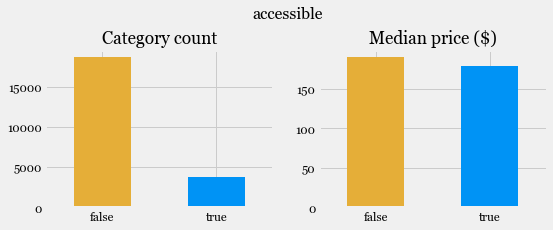

In [230]:
for col in df.iloc[:,42:].columns:
    binary_price_plot(col, figsize=(8,3))

In [231]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 65 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_location                22396 non-null  int64  
 1   host_experience              22396 non-null  float64
 2   response_time                22396 non-null  int64  
 3   response_rate                22396 non-null  float64
 4   superhost                    22396 non-null  int64  
 5   host_listings                22396 non-null  float64
 6   suburb                       22396 non-null  object 
 7   lga                          22396 non-null  object 
 8   latitude                     22396 non-null  float64
 9   longitude                    22396 non-null  float64
 10  dist_to_cbd                  22396 non-null  float64
 11  cafe_density                 22396 non-null  float64
 12  transport_rating             22396 non-null  float64
 13  beach_acc

In [232]:
# save dataframe to csv
df.to_csv('bnb_modeling.csv', header=True, index=True)